# effect of `gamma_max` prior on `respiv7` convergence
 * modified from 2020-05-16 notebook with a focus on the `gamma_max` prior and its effect on model convergence and fit
 
### general information about the different growth/respiration versions

 * for the functional form of the different size-dependent growth and respiration formulations see [this notebook](sizedep_formulations.ipynb) 

## load data from files and plot

In [1]:
#%matplotlib notebook
import netCDF4 as nc4
import numpy as np

# load data
datafiles = {
    'seaflow':'data/SeaFlow_SizeDist_regrid-25-8.nc',
    'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

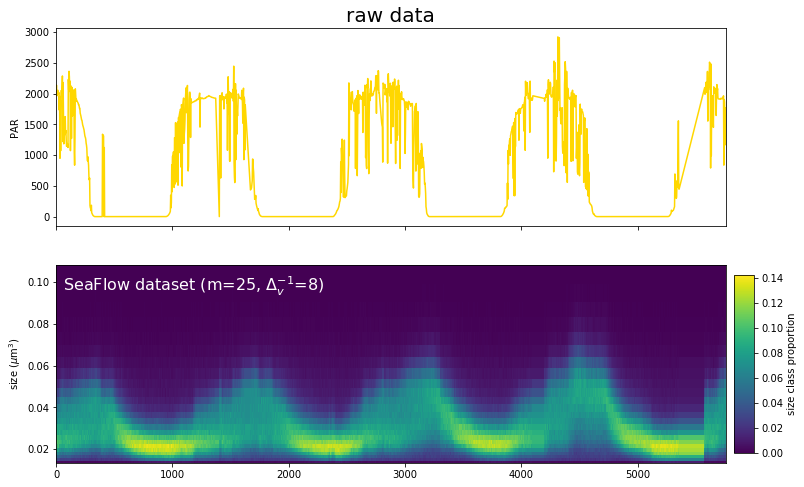

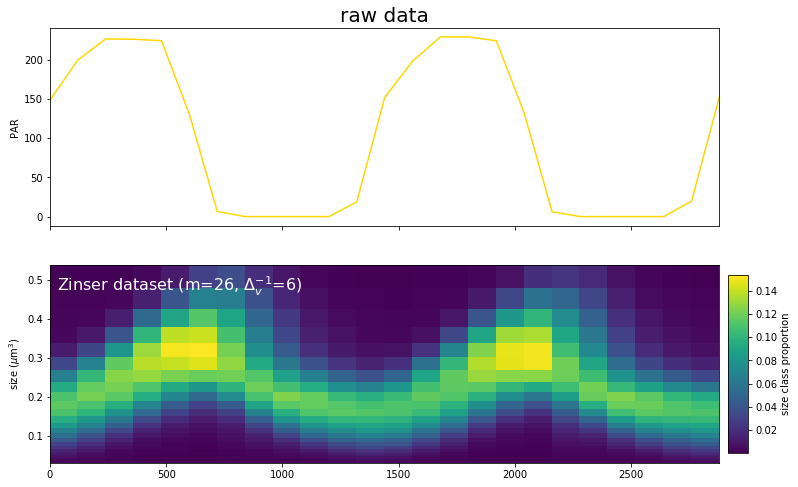

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

for i,dataname in enumerate(data_gridded):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('raw data', size=20)
    
    ax = axs[0]
    ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
    ax.set(ylabel='PAR')

    v_min = data_gridded[dataname]['v_min']
    delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data_gridded[dataname]['time'],v,data_gridded[dataname]['w_obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
axs[-1].set_xlabel=('time (minutes)')
None

## process data and plot it

In [3]:
# prepare data for Stan model

if 'data' not in globals():
    data = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'models' not in globals():
    models = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = 1
        
        # new: average SeaFlow data in hourly bins
        binsize = 60 # in minutes
        numbins = int(np.ceil(data_gridded[dataname]['time'][-1]/binsize))
        
        data[dataname]['obs'] = np.full((data[dataname]['m'],numbins), fill_value=np.nan)
        data[dataname]['t_obs'] = np.full(numbins, fill_value=np.nan)
        
        i = 0
        for ibin in range(numbins):
            binind = np.logical_and(data_gridded[dataname]['time'] >= ibin*binsize,
                                    data_gridded[dataname]['time'] < (ibin+1)*binsize)
            if np.any(binind):
                # TODO we may want to make this a sum when dealing with counts
                data[dataname]['obs'][:,i] = np.mean(data_gridded[dataname]['w_obs'][:,binind], axis=1)
                data[dataname]['t_obs'][i] = (ibin+0.5) * binsize
                i += 1
        
        data[dataname]['obs'] = data[dataname]['obs'][:,:i]
        data[dataname]['t_obs'] = data[dataname]['t_obs'][:i]
        
        # median filter PAR
        # see: medianfilter_par.ipynb
        n = len(data_gridded[dataname]['PAR'])
        wsh = 30 # half of median filter window size; window size is 2*wsh+1
        par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    # load cross-validation testing indices and add them to data
    data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
    # remove last index, so that dimensions agree
    data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # for now, add pseudo-count data
    data[dataname]['obs_count'] = (1000*data[dataname]['obs']).astype(int)
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

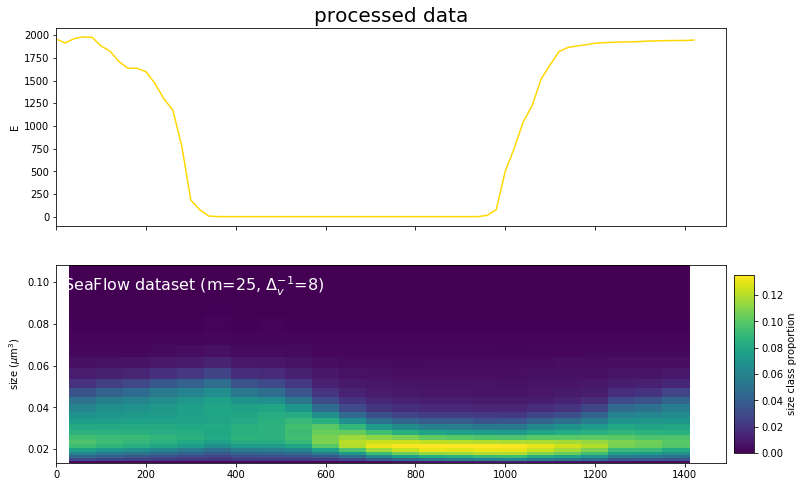

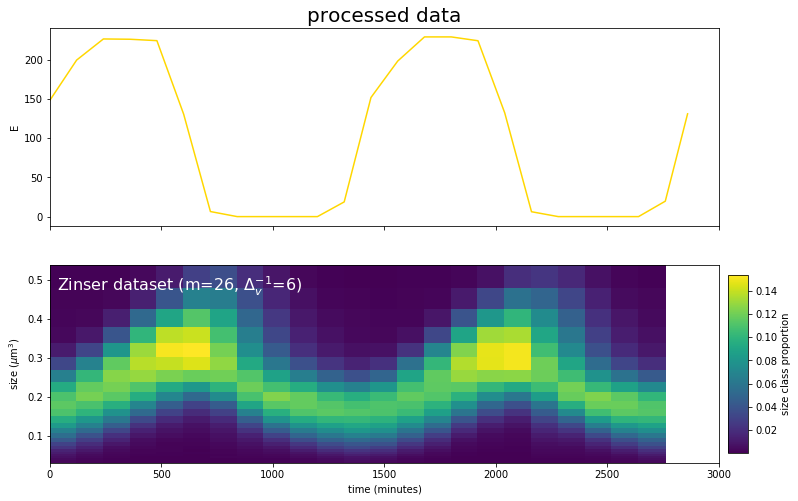

In [4]:
for i,dataname in enumerate(data):
    nrows = 2
    fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))
    axs[0].set_title('processed data', size=20)
    
    ax = axs[0]
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    ax.plot(t, data[dataname]['E'], color='gold')
    ax.set(ylabel='E')

    v_min = data[dataname]['v_min']
    delta_v = 1.0/data[dataname]['delta_v_inv']
    v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
    
    ax = axs[1]
    pc = ax.pcolormesh(data[dataname]['t_obs'],v,data[dataname]['obs'])
    ax.set(ylabel='size ($\mu$m$^3$)')
    ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
    add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
    ax.set_xlim(left=0.0)
axs[-1].set_xlabel('time (minutes)')

None

## run model

In [5]:
import pystan
import re

desc_model = {
    'v7_orig':'growth/respiration v7, original prior',
    'v7_m40':'growth/respiration v7, gamma_max < 40',
    'v7_m20':'growth/respiration v7, gamma_max < 20',
    'v7_m10':'growth/respiration v7, gamma_max < 10',
    'v7_n10':'growth/respiration v7, gamma_max ~ normal(10.0,5.0)',
}
# preparing for some regular expression magic
model_code_replacements = {
    'v7_orig':(),
    'v7_m40':(('^( *gamma_max *~)',' uniform(0.0, 40.0);'),),
    'v7_m20':(('^( *gamma_max *~)',' uniform(0.0, 20.0);'),),
    'v7_m10':(('^( *gamma_max *~)',' uniform(0.0, 10.0);'),),
    'v7_n10':(('^( *gamma_max *~)',' normal(10.0,5.0);'),('^( *real<lower=0)> gamma_max;',',upper=1440.0/dt> gamma_max;')),
}
model_stan_key = {
    'v7_orig':'monodelta_respiv7_mn',
    'v7_m40':'monodelta_respiv7_mn',
    'v7_m20':'monodelta_respiv7_mn',
    'v7_m10':'monodelta_respiv7_mn',
    'v7_n10':'monodelta_respiv7_mn',
}
stan_files = {
    'monodelta_respiv7_mn':'stancode/matrixmodel_multinom_estinilnorm_monodelta_respiv7_normparam_trackgrowth_xval.stan',
}

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for name in desc_model:
    code_split = stan_base_code[model_stan_key[name]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[name]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(name, line_new))
        code_split_new.append(line_new)
                
    stan_code[name] = '\n'.join(code_split_new)

for name in desc_model:
    refit_required[name] = True
    if name in models and models[name].model_code == stan_code[name]:
        print('{}: unchanged code, not recompiling'.format(name))
        refit_required[name] = False
    else:
        if name in models:
            print('{}: code change detected, recompiling'.format(name))
        else:
            print('{}: compiling'.format(name))
        models[name] = pystan.StanModel(model_code=stan_code[name], model_name=name, obfuscate_model_name=False)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_orig NOW.


v7_m40: patching in "    gamma_max ~ uniform(0.0, 40.0);"
v7_m20: patching in "    gamma_max ~ uniform(0.0, 20.0);"
v7_m10: patching in "    gamma_max ~ uniform(0.0, 10.0);"
v7_orig: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_m40 NOW.


v7_m40: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_m20 NOW.


v7_m20: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL v7_m10 NOW.


v7_m10: compiling


In [6]:
import time
refit_all = False
refit_required = {}

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'maxrhats' not in globals():
    maxrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}

    
try_again = False

# run a bunch of experiments -- this may take a while
for name in models:
    if name not in maxrhats:
        maxrhats[name] = {}
    if name not in sampling_time:
        sampling_time[name] = {}
    for dataname in data:
        if dataname not in maxrhats[name]:
            maxrhats[name][dataname] = []
        if dataname not in sampling_time[name]:
            sampling_time[name][dataname] = []
        if name in mcmcs:
            if dataname in mcmcs[name] and not refit_all and not refit_required[name]:
                print('{} ({})'.format(name, desc_model[name])) 
                print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))
                rhat_max = get_max_rhat(mcmcs[name][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(name,rhat_max))
                else:
                    continue
        else:
            mcmcs[name] = {}
        for itry in range(3):
            t0 = time.time()
            mcmcs[name][dataname] = models[name].sampling(data=data[dataname], iter=2000)
            sampling_time[name][dataname].append(time.time() - t0) # in seconds
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[name][dataname])
            maxrhats[name][dataname].append(rhat_max)
            if rhat_max < 1.1:
                break
            print('{}: in try {}/3 found Rhat={:.3f}, trying again'.format(name,itry+1,rhat_max))
        print('{} ({})'.format(name, desc_model[name])) 
        print('\n'.join(x for x in mcmcs[name][dataname].__str__().split('\n') if 'mod_obspos' not in x and 'theta' not in x and 'w_ini' not in x and 'incr' not in x))

v7_orig (growth/respiration v7, original prior)
Inference for Stan model: v7_orig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.31  2.9e-3    0.09    0.18    0.25     0.3    0.36    0.51    905    1.0
gamma_max              1.3  1.6e-3    0.05     1.2    1.27     1.3    1.34    1.41   1050    1.0
xi                    0.04  3.3e-3     0.1   -0.15   -0.03    0.04     0.1    0.23    828   1.01
xir                -3.9e-4  2.8e-3    0.09   -0.18   -0.06 -3.0e-3    0.06    0.19   1110   1.01
respiration           0.11  7.6e-4    0.02    0.07     0.1    0.11    0.12    0.15    762   1.01
E_star                9.66    0.83   23.23    0.09    0.79    1.71    4.56   69.42    790    1.0
divrate               0.68  9.4e-4    0.03    0.62    0.66    0.68    0.69    0.73    882    1.0
delta_max[1]          0

v7_orig: in try 1/3 found Rhat=362.915, trying again


v7_orig (growth/respiration v7, original prior)
Inference for Stan model: v7_orig.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          2.25  7.4e-3    0.53    1.36    1.87     2.2    2.57    3.42   5006    1.0
gamma_max             7.56 10.0e-3    0.51    6.79    7.21    7.49    7.83    8.73   2667    1.0
xi                   -1.32  1.5e-3    0.09   -1.51   -1.39   -1.32   -1.26   -1.14   4145    1.0
xir                   0.45  1.5e-3    0.09    0.27    0.39    0.45    0.52    0.64   4052    1.0
respiration           1.69  1.4e-3    0.08    1.53    1.63    1.69    1.75    1.86   3415    1.0
E_star              116.29     0.4   21.06   84.65  101.64  113.26  127.51  164.78   2777    1.0
divrate               0.64  6.8e-4    0.04    0.57    0.62    0.64    0.67    0.72   3562    1.0
delta_max[1]          0

v7_m40 (growth/respiration v7, gamma_max < 40)
Inference for Stan model: v7_m40.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.31  3.5e-3    0.09    0.17    0.25     0.3    0.36    0.52    665   1.01
gamma_max              1.3  1.7e-3    0.05     1.2    1.27     1.3    1.34    1.41   1012    1.0
xi                    0.03  2.8e-3     0.1   -0.16   -0.04    0.02    0.09    0.22   1208    1.0
xir                 3.0e-3  3.6e-3     0.1    -0.2   -0.07  2.9e-3    0.07    0.21    781   1.01
respiration           0.11  8.7e-4    0.02    0.06     0.1    0.11    0.12    0.15    590   1.01
E_star                9.89    1.04   31.57    0.08    0.85    1.75    3.99   72.06    927    1.0
divrate               0.68  1.1e-3    0.03    0.62    0.66    0.68     0.7    0.73    699   1.01
delta_max[1]          0.0

v7_m20 (growth/respiration v7, gamma_max < 20)
Inference for Stan model: v7_m20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.31  3.6e-3    0.09    0.17    0.25    0.29    0.36    0.52    620   1.01
gamma_max              1.3  2.2e-3    0.06    1.19    1.26     1.3    1.34    1.42    686   1.01
xi                    0.03  3.1e-3     0.1   -0.17   -0.03    0.03    0.09    0.22    987    1.0
xir                 3.7e-3  3.7e-3     0.1    -0.2   -0.06  5.2e-3    0.07     0.2    764    1.0
respiration           0.11  9.6e-4    0.02    0.06    0.09    0.11    0.12    0.15    527    1.0
E_star                 8.3    0.81   19.37     0.1    0.84    1.66    3.76   69.88    570   1.01
divrate               0.68  1.2e-3    0.03    0.62    0.66    0.68     0.7    0.73    579    1.0
delta_max[1]          0.0

v7_m20: in try 1/3 found Rhat=131.000, trying again


v7_m20: in try 2/3 found Rhat=3926.872, trying again


v7_m20: in try 3/3 found Rhat=5724.383, trying again
v7_m20 (growth/respiration v7, gamma_max < 20)
Inference for Stan model: v7_m20.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean      sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.24    0.71    1.06    0.16    0.24    0.58   2.17   3.22      2   2.95
gamma_max           13.78     4.4    6.23    6.88    7.49   15.04   20.0   20.0      2  18.77
xi                   -2.1    1.54    2.18   -5.76   -3.88   -1.32  -0.46 6.8e-5      2  34.91
xir                  3.13    1.89    2.68    0.29    0.46     3.2   5.83   6.04      2  41.02
respiration          1.25    0.34    0.49    0.51    0.79    1.24   1.69   1.83      2   8.56
E_star              725.5  430.69  609.39    87.4  113.99  771.35 1334.4 1337.1      2  45.18
divrate              1.27    0.48    0.67    0.58    0.64    1.15   1.92   2.25      2  23

v7_m10 (growth/respiration v7, gamma_max < 10)
Inference for Stan model: v7_m10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                      mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
delta_lambda          0.32  3.9e-3    0.09    0.18    0.25     0.3    0.37    0.54    585    1.0
gamma_max              1.3  2.0e-3    0.06    1.19    1.26     1.3    1.34    1.41    813    1.0
xi                    0.03  3.2e-3     0.1   -0.16   -0.04    0.03     0.1    0.22    931    1.0
xir                -9.3e-4  2.8e-3     0.1   -0.19   -0.07 -1.6e-3    0.06    0.19   1182    1.0
respiration           0.11  7.5e-4    0.02    0.07     0.1    0.11    0.12    0.15    782    1.0
E_star               10.09    0.89   22.61    0.09    0.82    1.86    4.89    71.2    647    1.0
divrate               0.68  8.9e-4    0.03    0.62    0.66    0.68    0.69    0.73    987    1.0
delta_max[1]          0.0

v7_m10: in try 1/3 found Rhat=507.546, trying again


v7_m10: in try 2/3 found Rhat=7360.267, trying again


v7_m10: in try 3/3 found Rhat=3608.636, trying again
v7_m10 (growth/respiration v7, gamma_max < 10)
Inference for Stan model: v7_m10.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                     mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
delta_lambda         1.01     0.6   0.89    0.22    0.23    0.65   1.35   2.88      2   3.54
gamma_max            9.39    0.75   1.08    7.03    9.88    10.0   10.0   10.0      2   4.89
xi                  -4.15    1.72   2.43   -7.35   -6.56   -3.97   -1.9  -1.21      2  57.32
xir                 -1.86    3.43   4.85   -7.19   -6.48   -2.73   3.04   4.93      2 110.34
respiration          1.01    0.42   0.59    0.28    0.42    0.98    1.5   1.81      2  14.39
E_star             1697.4  1057.3 1495.7   93.07  290.39  1493.2 3194.1 3685.6      2 162.09
divrate              1.17     0.3   0.43    0.59    0.91    1.11   1.52   1.84      2  21.43
delt

## plot the results

In [7]:
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (24,12)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

maxrhats_final = {name:{dataname:get_max_rhat(mcmcs[name][dataname]) for dataname in data} for name in mcmcs}        

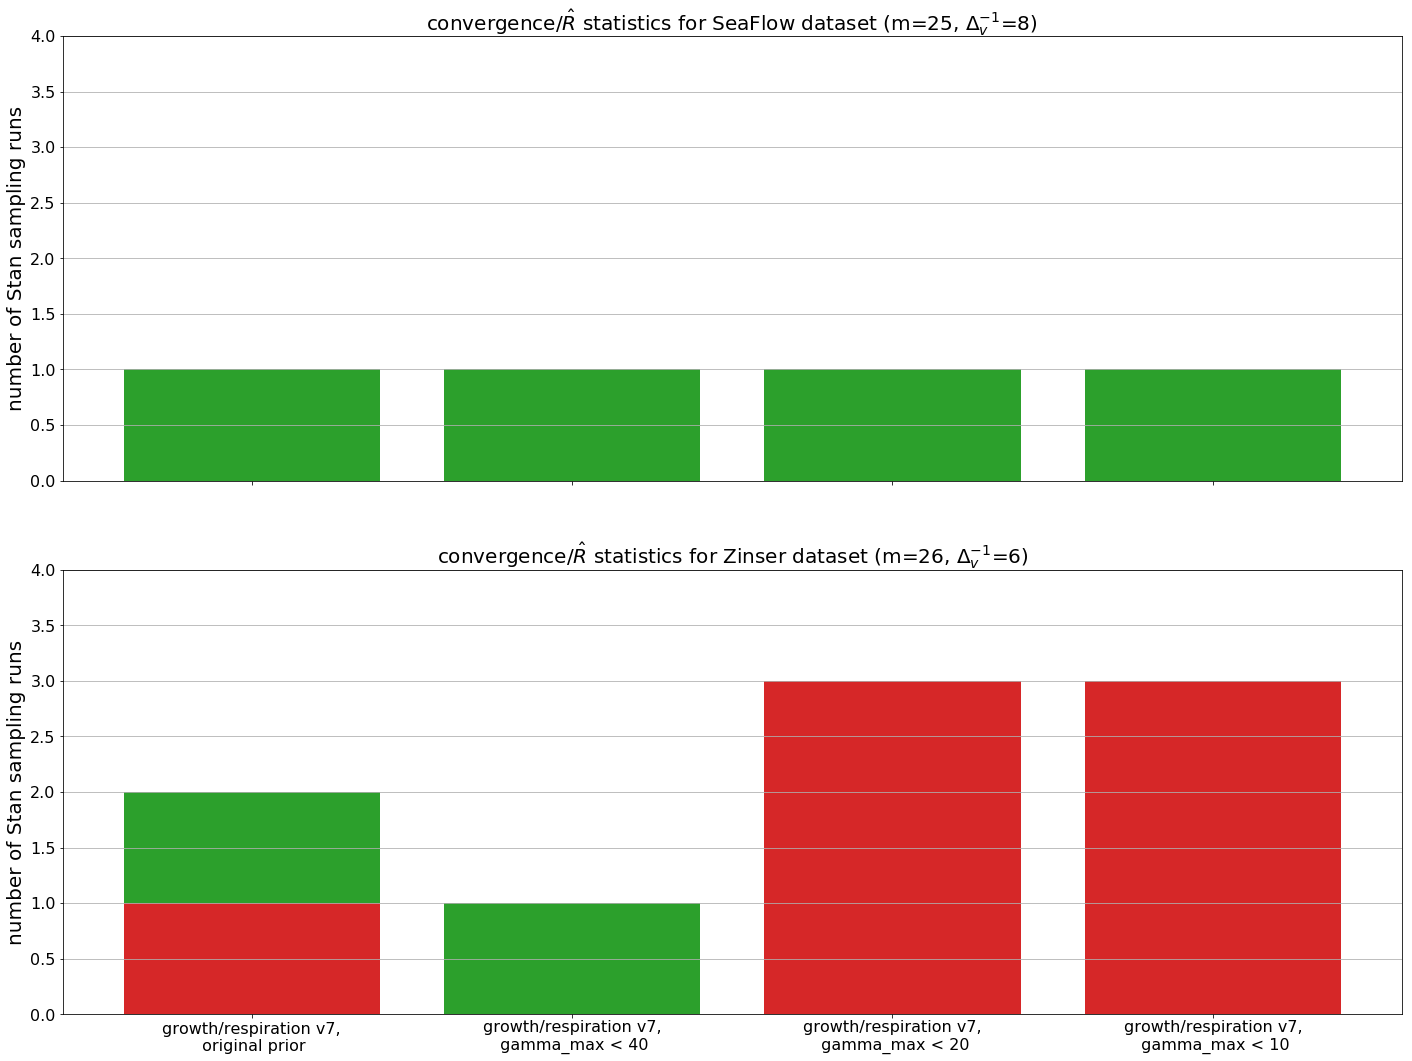

In [8]:
ylim_top = 0
for dataname in data:
    for name in mcmcs:
        ylim_top = max(ylim_top, len(maxrhats[name][dataname]))
ylim_top += 1

fig, axs = plt.subplots(nrows=len(data), figsize=(max(24,len(mcmcs)*4.5),len(data)*9), sharex=True, sharey=True)
for ax,dataname in zip(axs.flat,data):
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        
        height_bad = sum(rh > 1.1 for rh in maxrhats[name][dataname])
        height_good = len(maxrhats[name][dataname]) - height_bad
        
        x = i
        ax.bar(x=x, height=height_bad, color='tab:red', label='max $\\\\hat{R}$ > 1.1')
        ax.bar(x=x, height=height_good, bottom=height_bad, color='tab:green', label='max $\\hat{R} \le$ 1.1')
        xticks.append(x)
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    ax.set(ylabel='number of Stan sampling runs', xticks=xticks, ylim=(0, ylim_top))
    ax.set_title('convergence/$\hat{R}$ statistics for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

fig, ax = plt.subplots(figsize=(16,16))
for dataname in data:
    for name in mcmcs:
        ax.scatter(maxrhats[name][dataname], sampling_time[name][dataname], label='{} ({})'.format(desc_model[name], dataname))

ax.set(xlabel='max $\\hat{R}$', ylabel='runtime')
ax.set_xscale('log')
ax.le

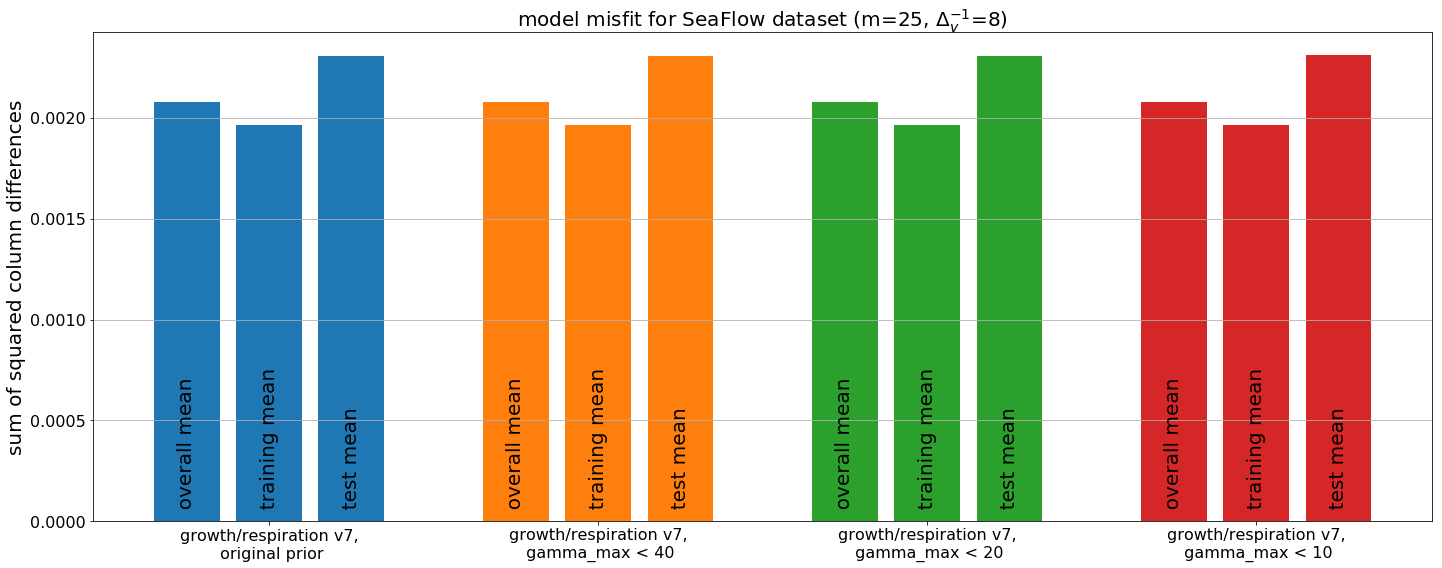

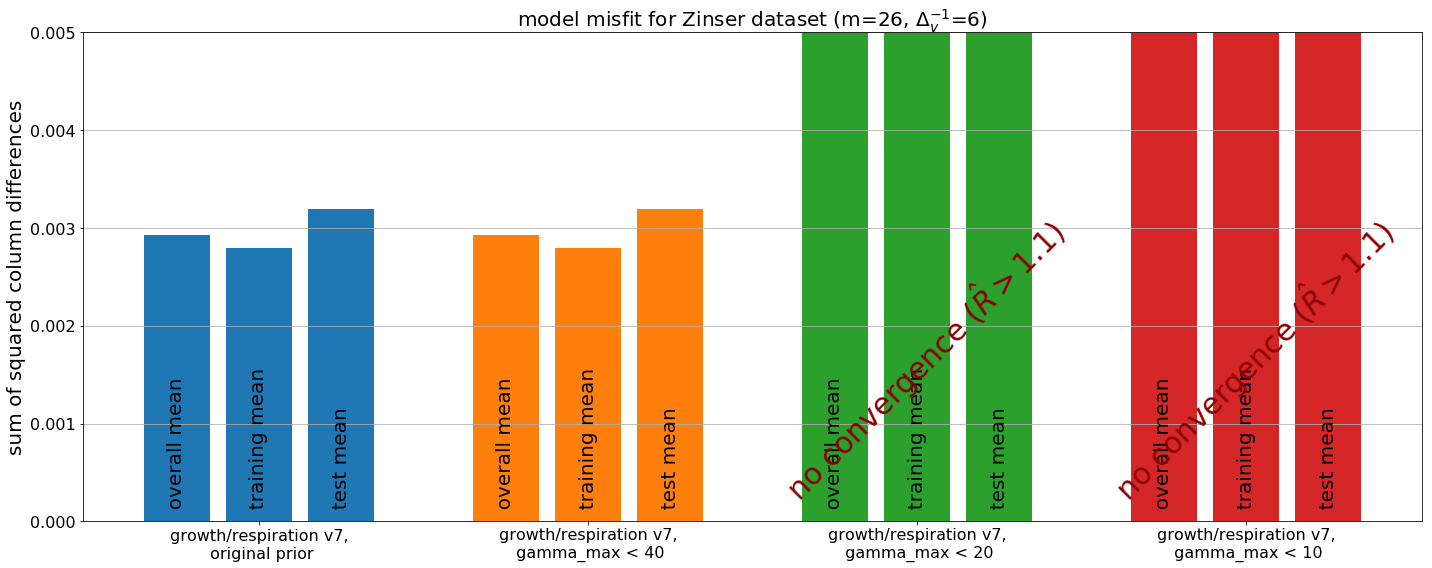

In [9]:
height = np.zeros(3)
for dataname in data:
    obs = data[dataname]['obs']
    
    fig, ax = plt.subplots(figsize=(max(24,len(mcmcs)*4.5),9))
    xticks = []
    xticklabels = []
    for i,name in enumerate(mcmcs):
        mod_mean = np.mean(mcmcs[name][dataname]['mod_obspos'], axis=0)
        mod_mean /= np.sum(mod_mean, axis=0)
        
        e = np.sum((mod_mean-obs)**2,axis=0)
        #print(desc_model[name],e)
        
        height[0] = np.mean(e)
        height[1] = np.mean(e[data[dataname]['i_test'] == 0])
        height[2] = np.mean(e[data[dataname]['i_test'] == 1])
        
        x = 4*i+np.arange(3)
        ax.bar(x=x, height=height)
        for xx,text in zip(x,['overall mean','training mean','test mean']):
            ax.text(xx, 0, '  '+text, rotation=90, ha='center', va='bottom', size=20)
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(x[1], 0, '  no convergence ($\\hat{R}>1.1$)', rotation=45, ha='center', va='bottom', size=30, color='darkred')
        xticks.append(x[1])
        xticklabels.append(desc_model[name].replace(',',',\n'))
    
    if ax.get_ylim()[1] > 0.005:
        ax.set_ylim(top=0.005)
    ax.set(ylabel='sum of squared column differences', xticks=xticks)
    ax.set_title('model misfit for '+desc[dataname], size=20)
    ax.set_xticklabels(xticklabels)#, rotation=8)
    ax.grid(axis='y')

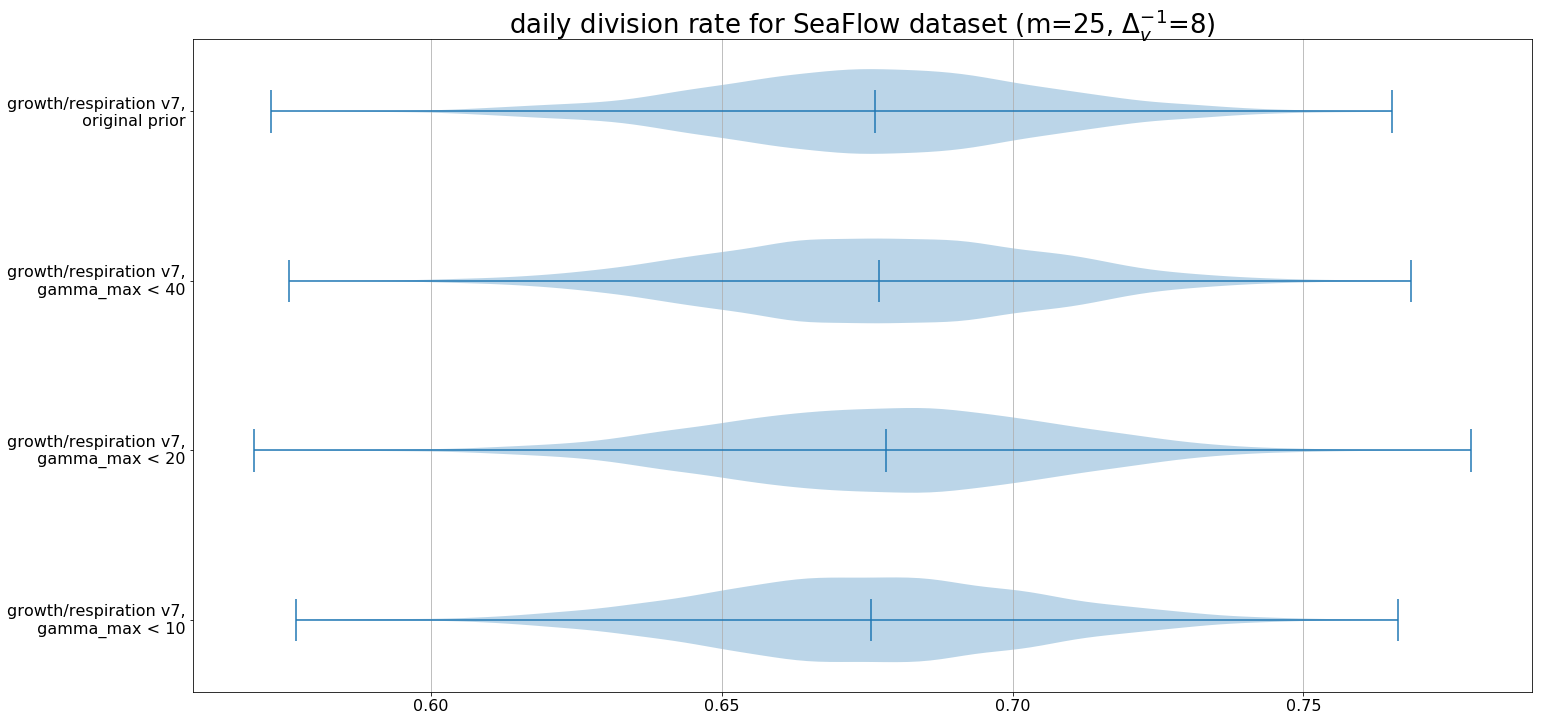

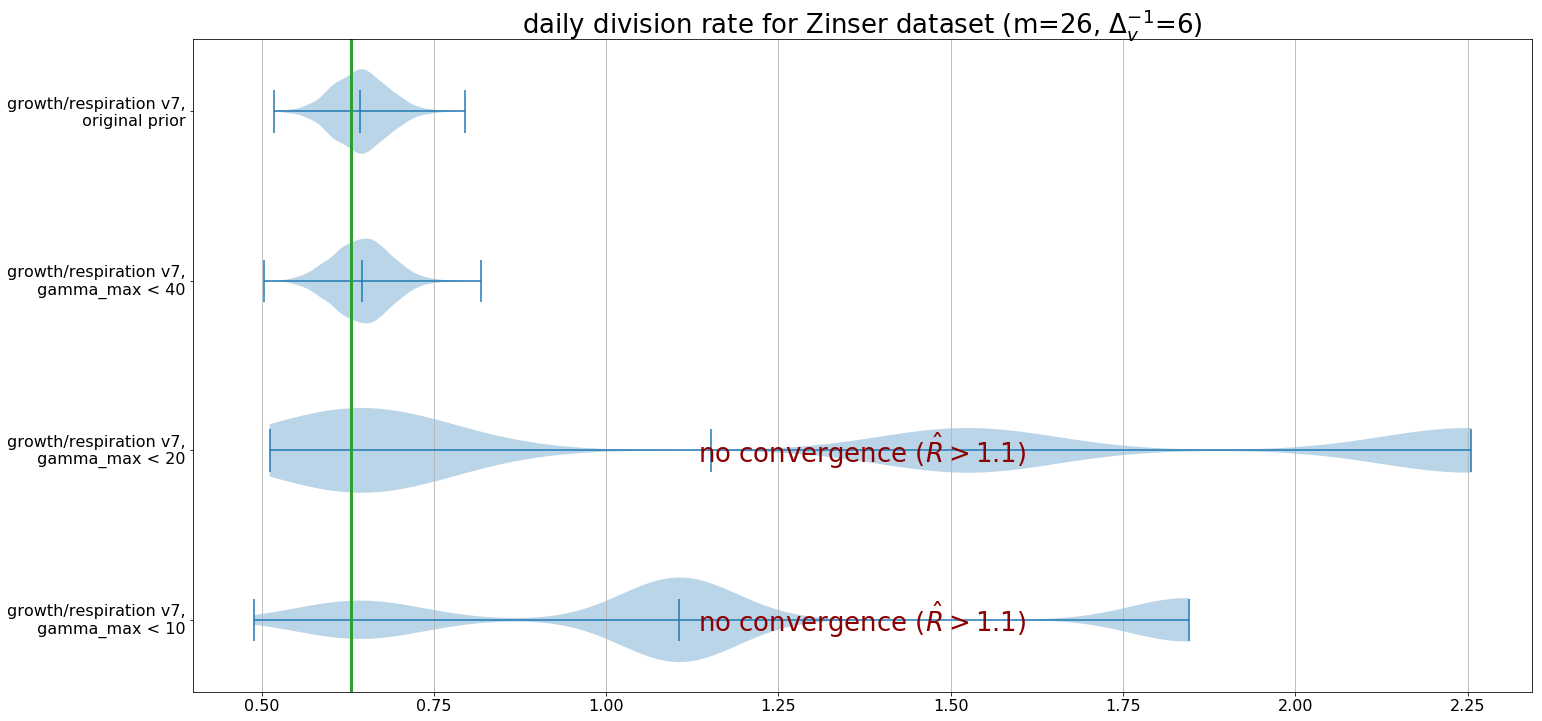

In [10]:
for dataname in data:
    num_mcmcs = len(mcmcs)
    fig, ax = plt.subplots(figsize=(24,3*num_mcmcs))
    ax.set_title('daily division rate for '+desc[dataname])
    ax.violinplot([mcmcs[name][dataname]['divrate'] for name in mcmcs], showmedians=True, vert=False)
    ax.invert_yaxis()
    ax.grid(axis='x')
    ax.set(yticks=np.arange(1,num_mcmcs+1), yticklabels=[desc_model[name].replace(',',',\n') for name in mcmcs])
    if 'zinser' in dataname:
        ax.axvline(0.63, color='tab:green', lw=3)
    for i,name in enumerate(mcmcs):
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, i+1, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.get_yaxis_transform(), ha='center', va='center')

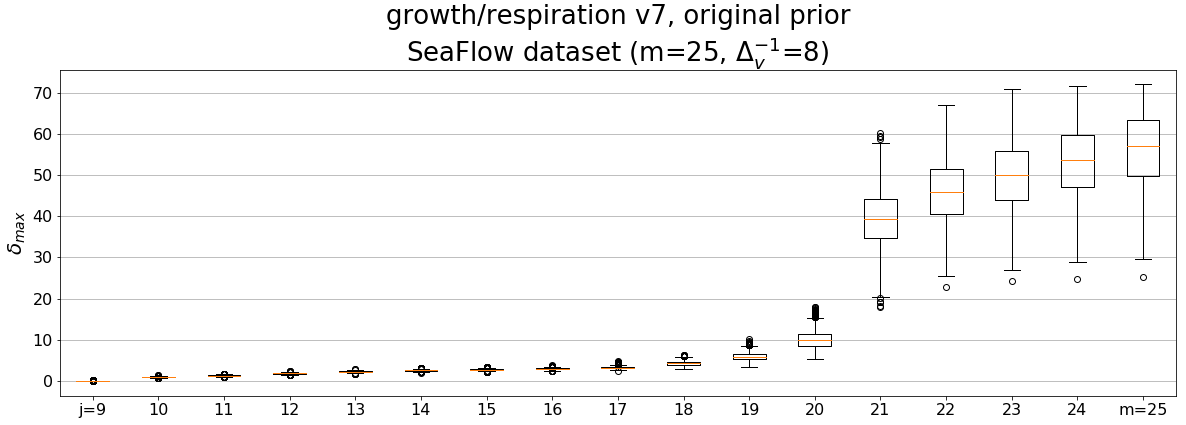

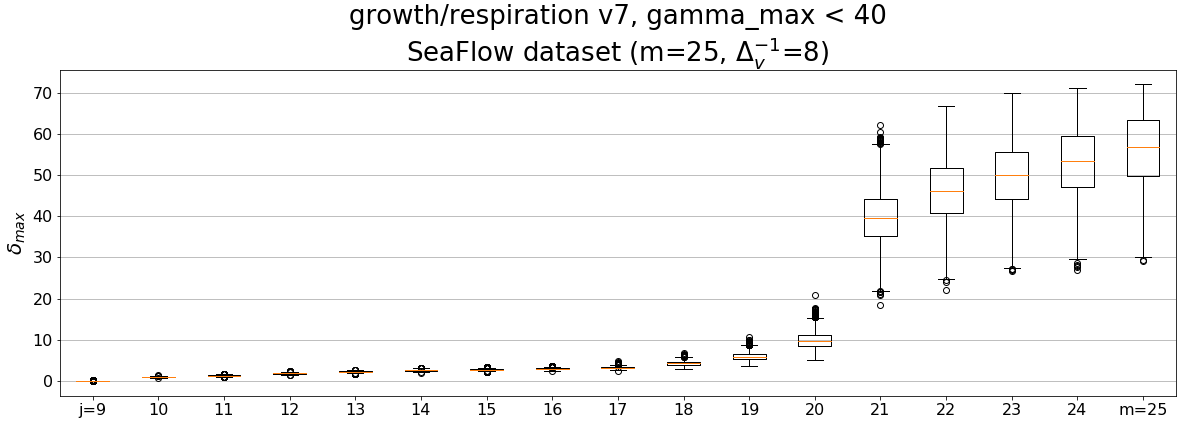

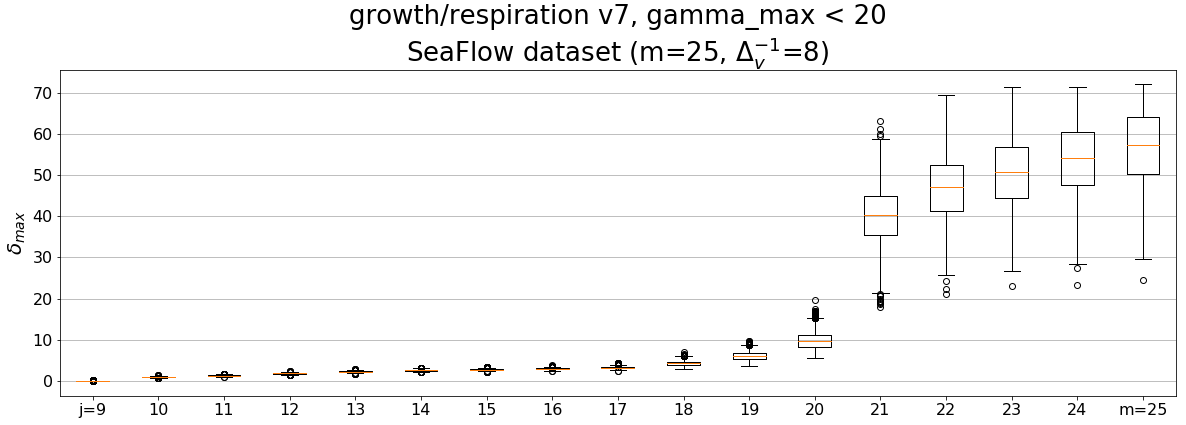

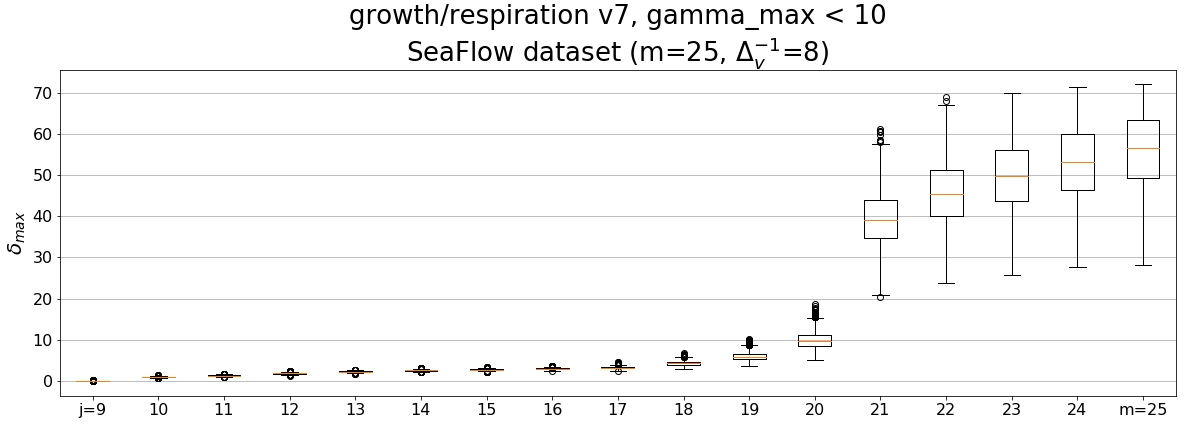

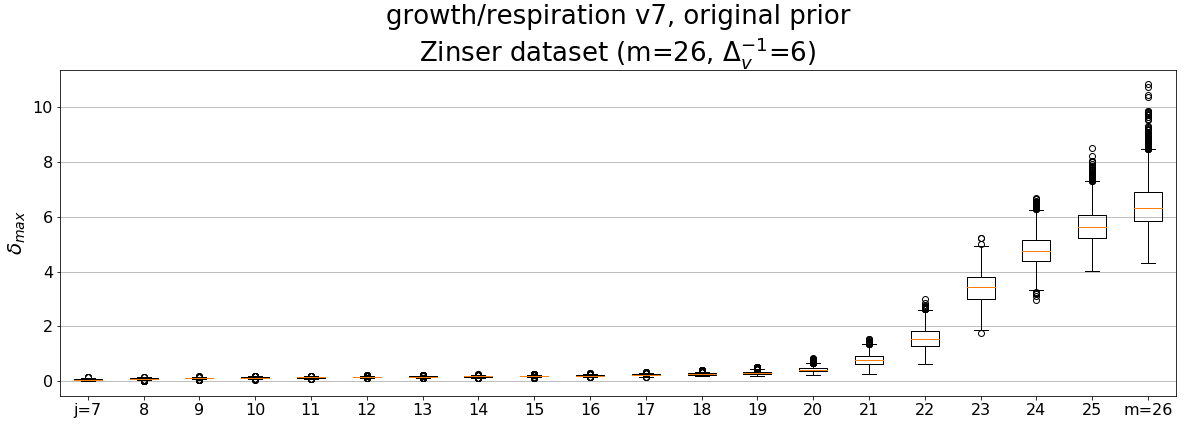

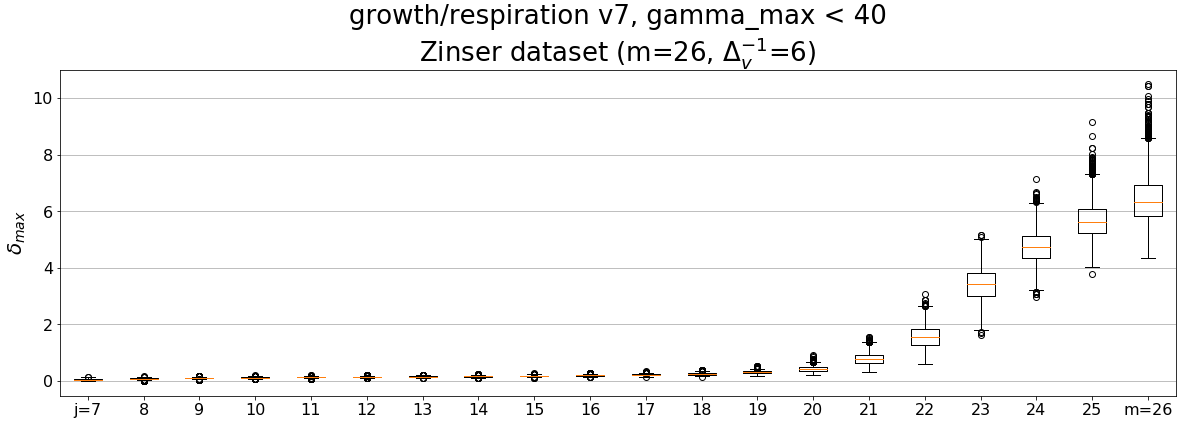

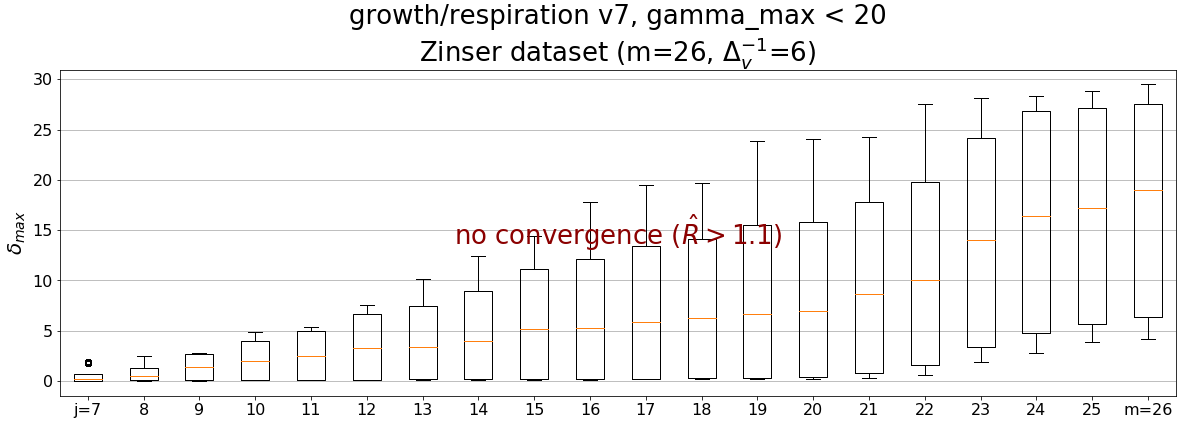

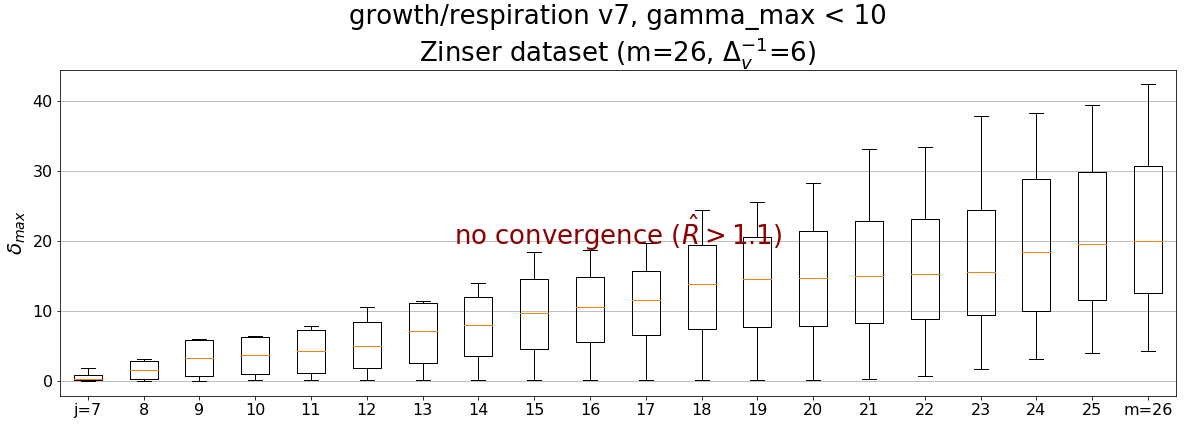

In [11]:
for dataname in data:
    for name,mcmc in mcmcs.items():
        j = data_gridded[dataname]['delta_v_inv'] + 1
        m = data_gridded[dataname]['m']

        fig, ax = plt.subplots(figsize=(20,6))
        ax.set_title(desc_model[name] + '\n' + desc[dataname])
        ax.boxplot(mcmc[dataname]['delta_max'])
        xlabels = [str(x) for x in range(j,m+1)]
        xlabels[0] = 'j='+xlabels[0]
        xlabels[-1] = 'm='+xlabels[-1]
        ax.set_xticklabels(xlabels)
        ax.grid(axis='y')
        ax.set_ylabel('$\\delta_{max}$')
        
        if maxrhats_final[name][dataname] > 1.1:
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
        None

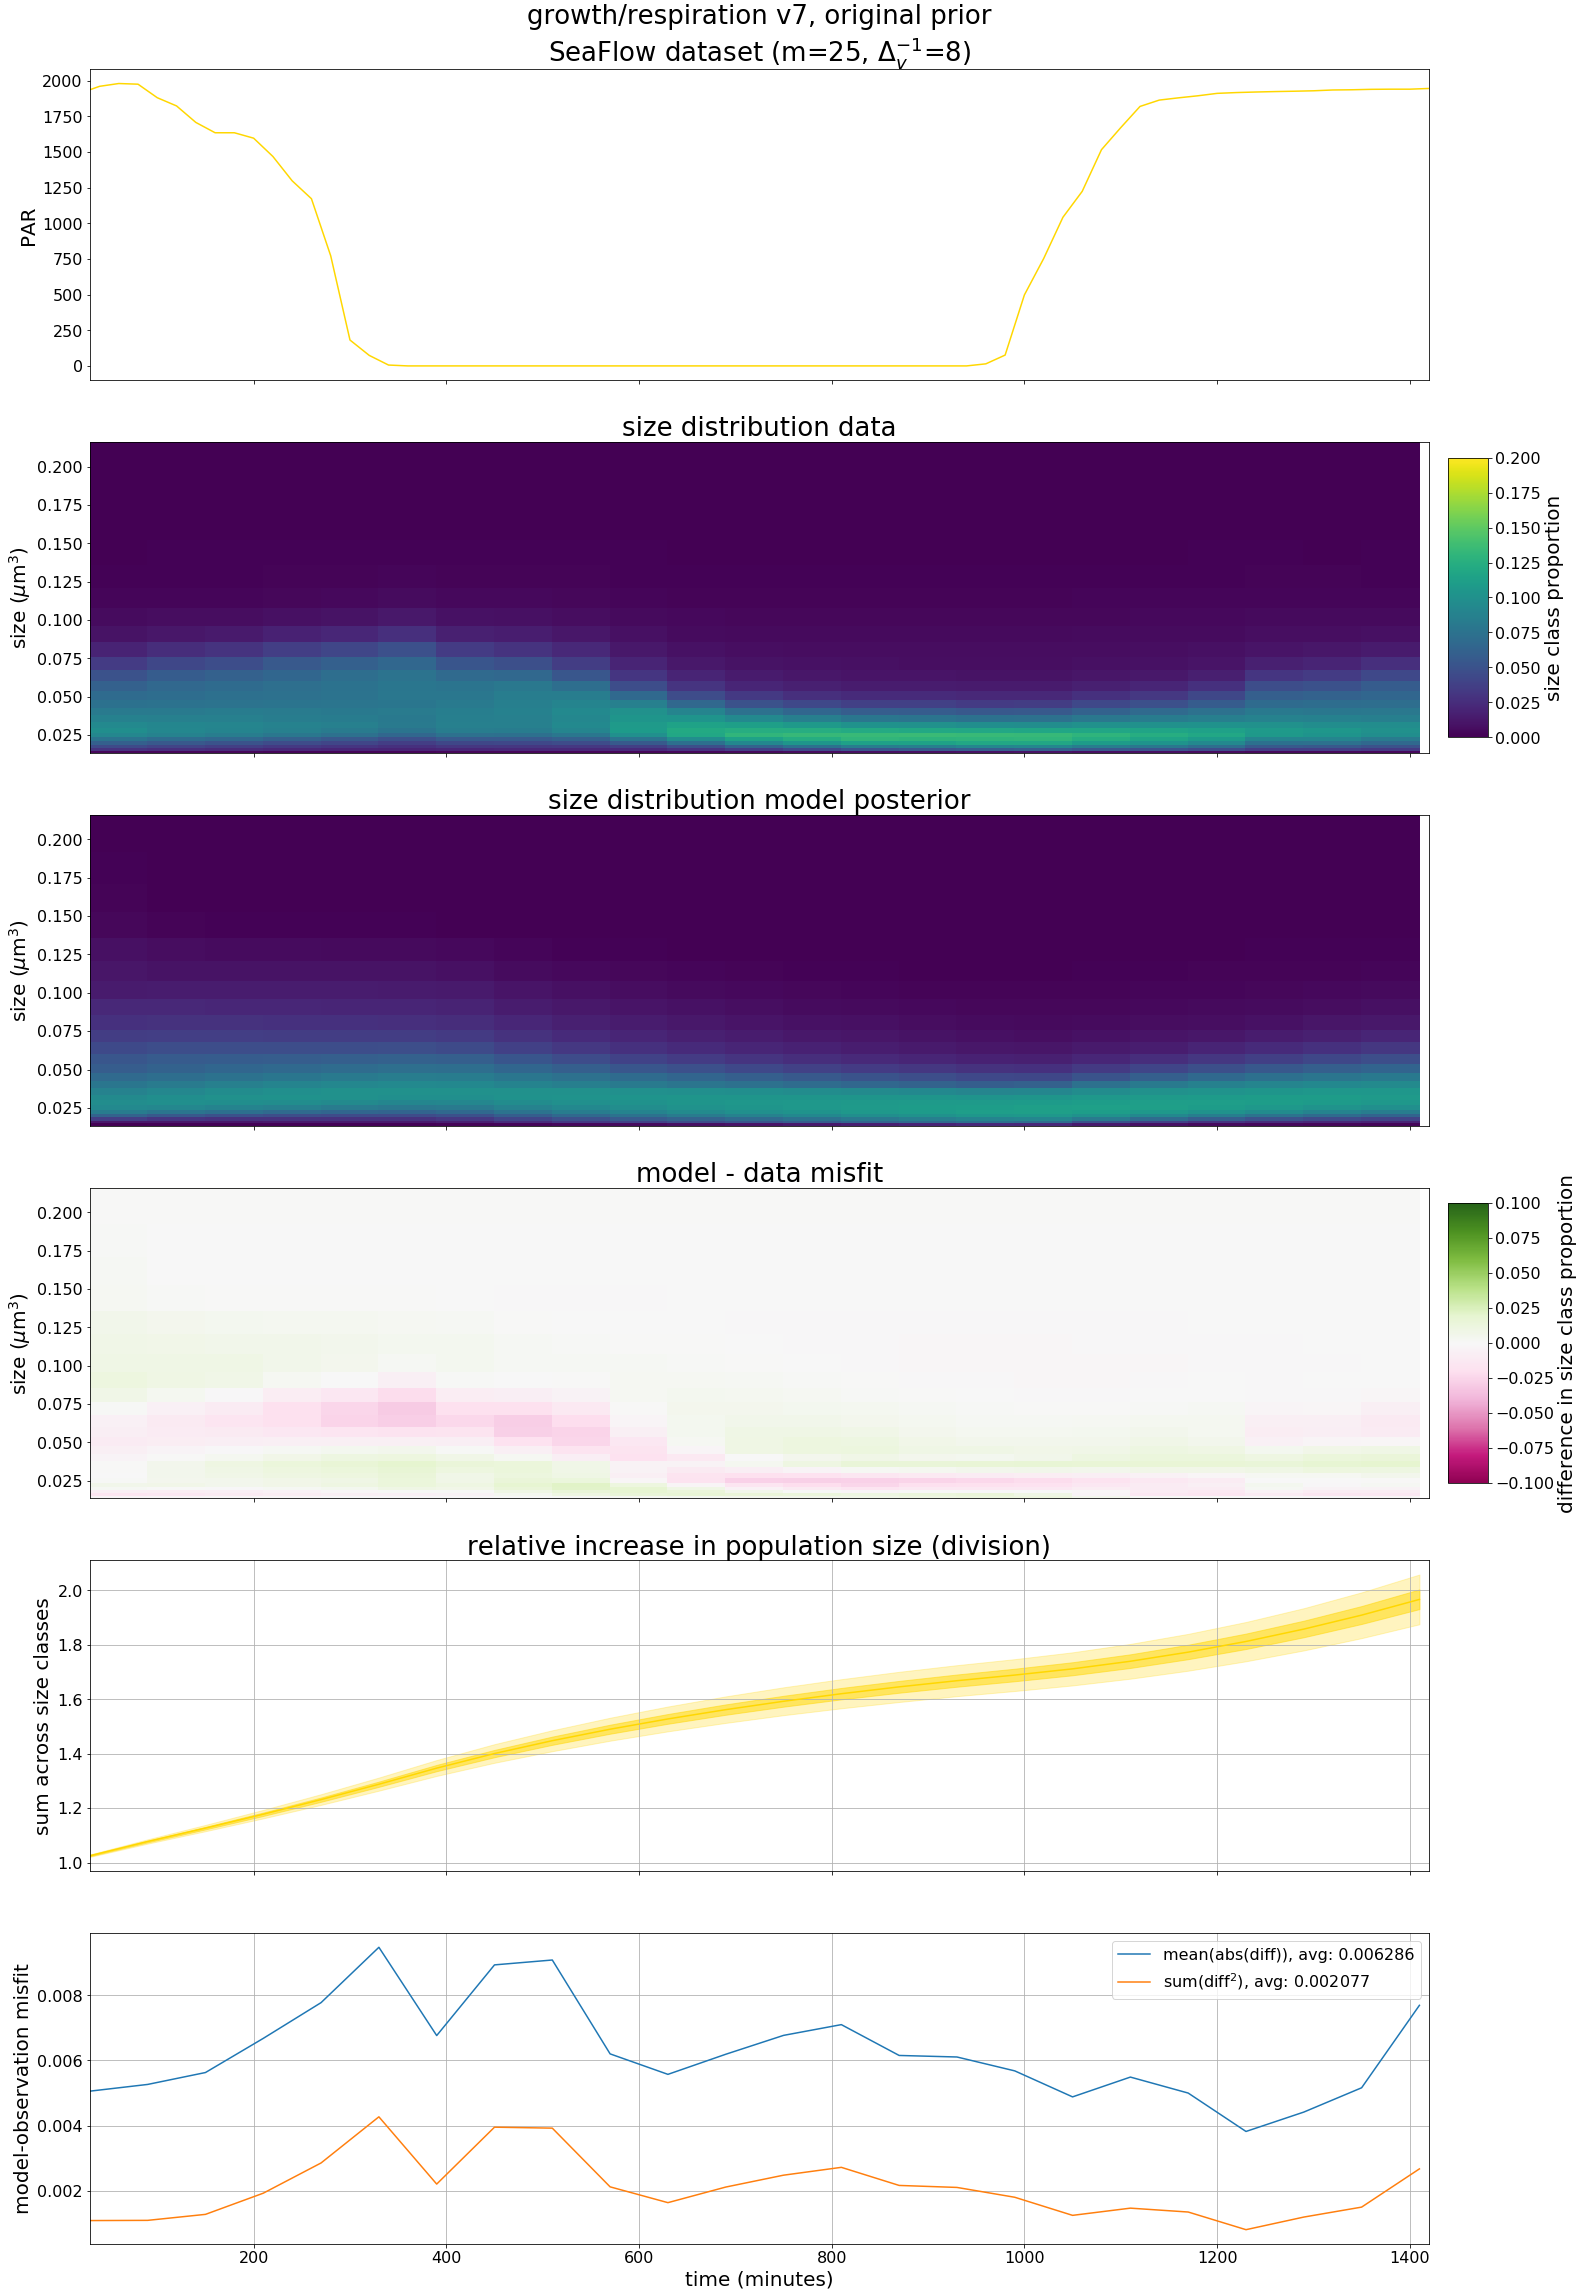

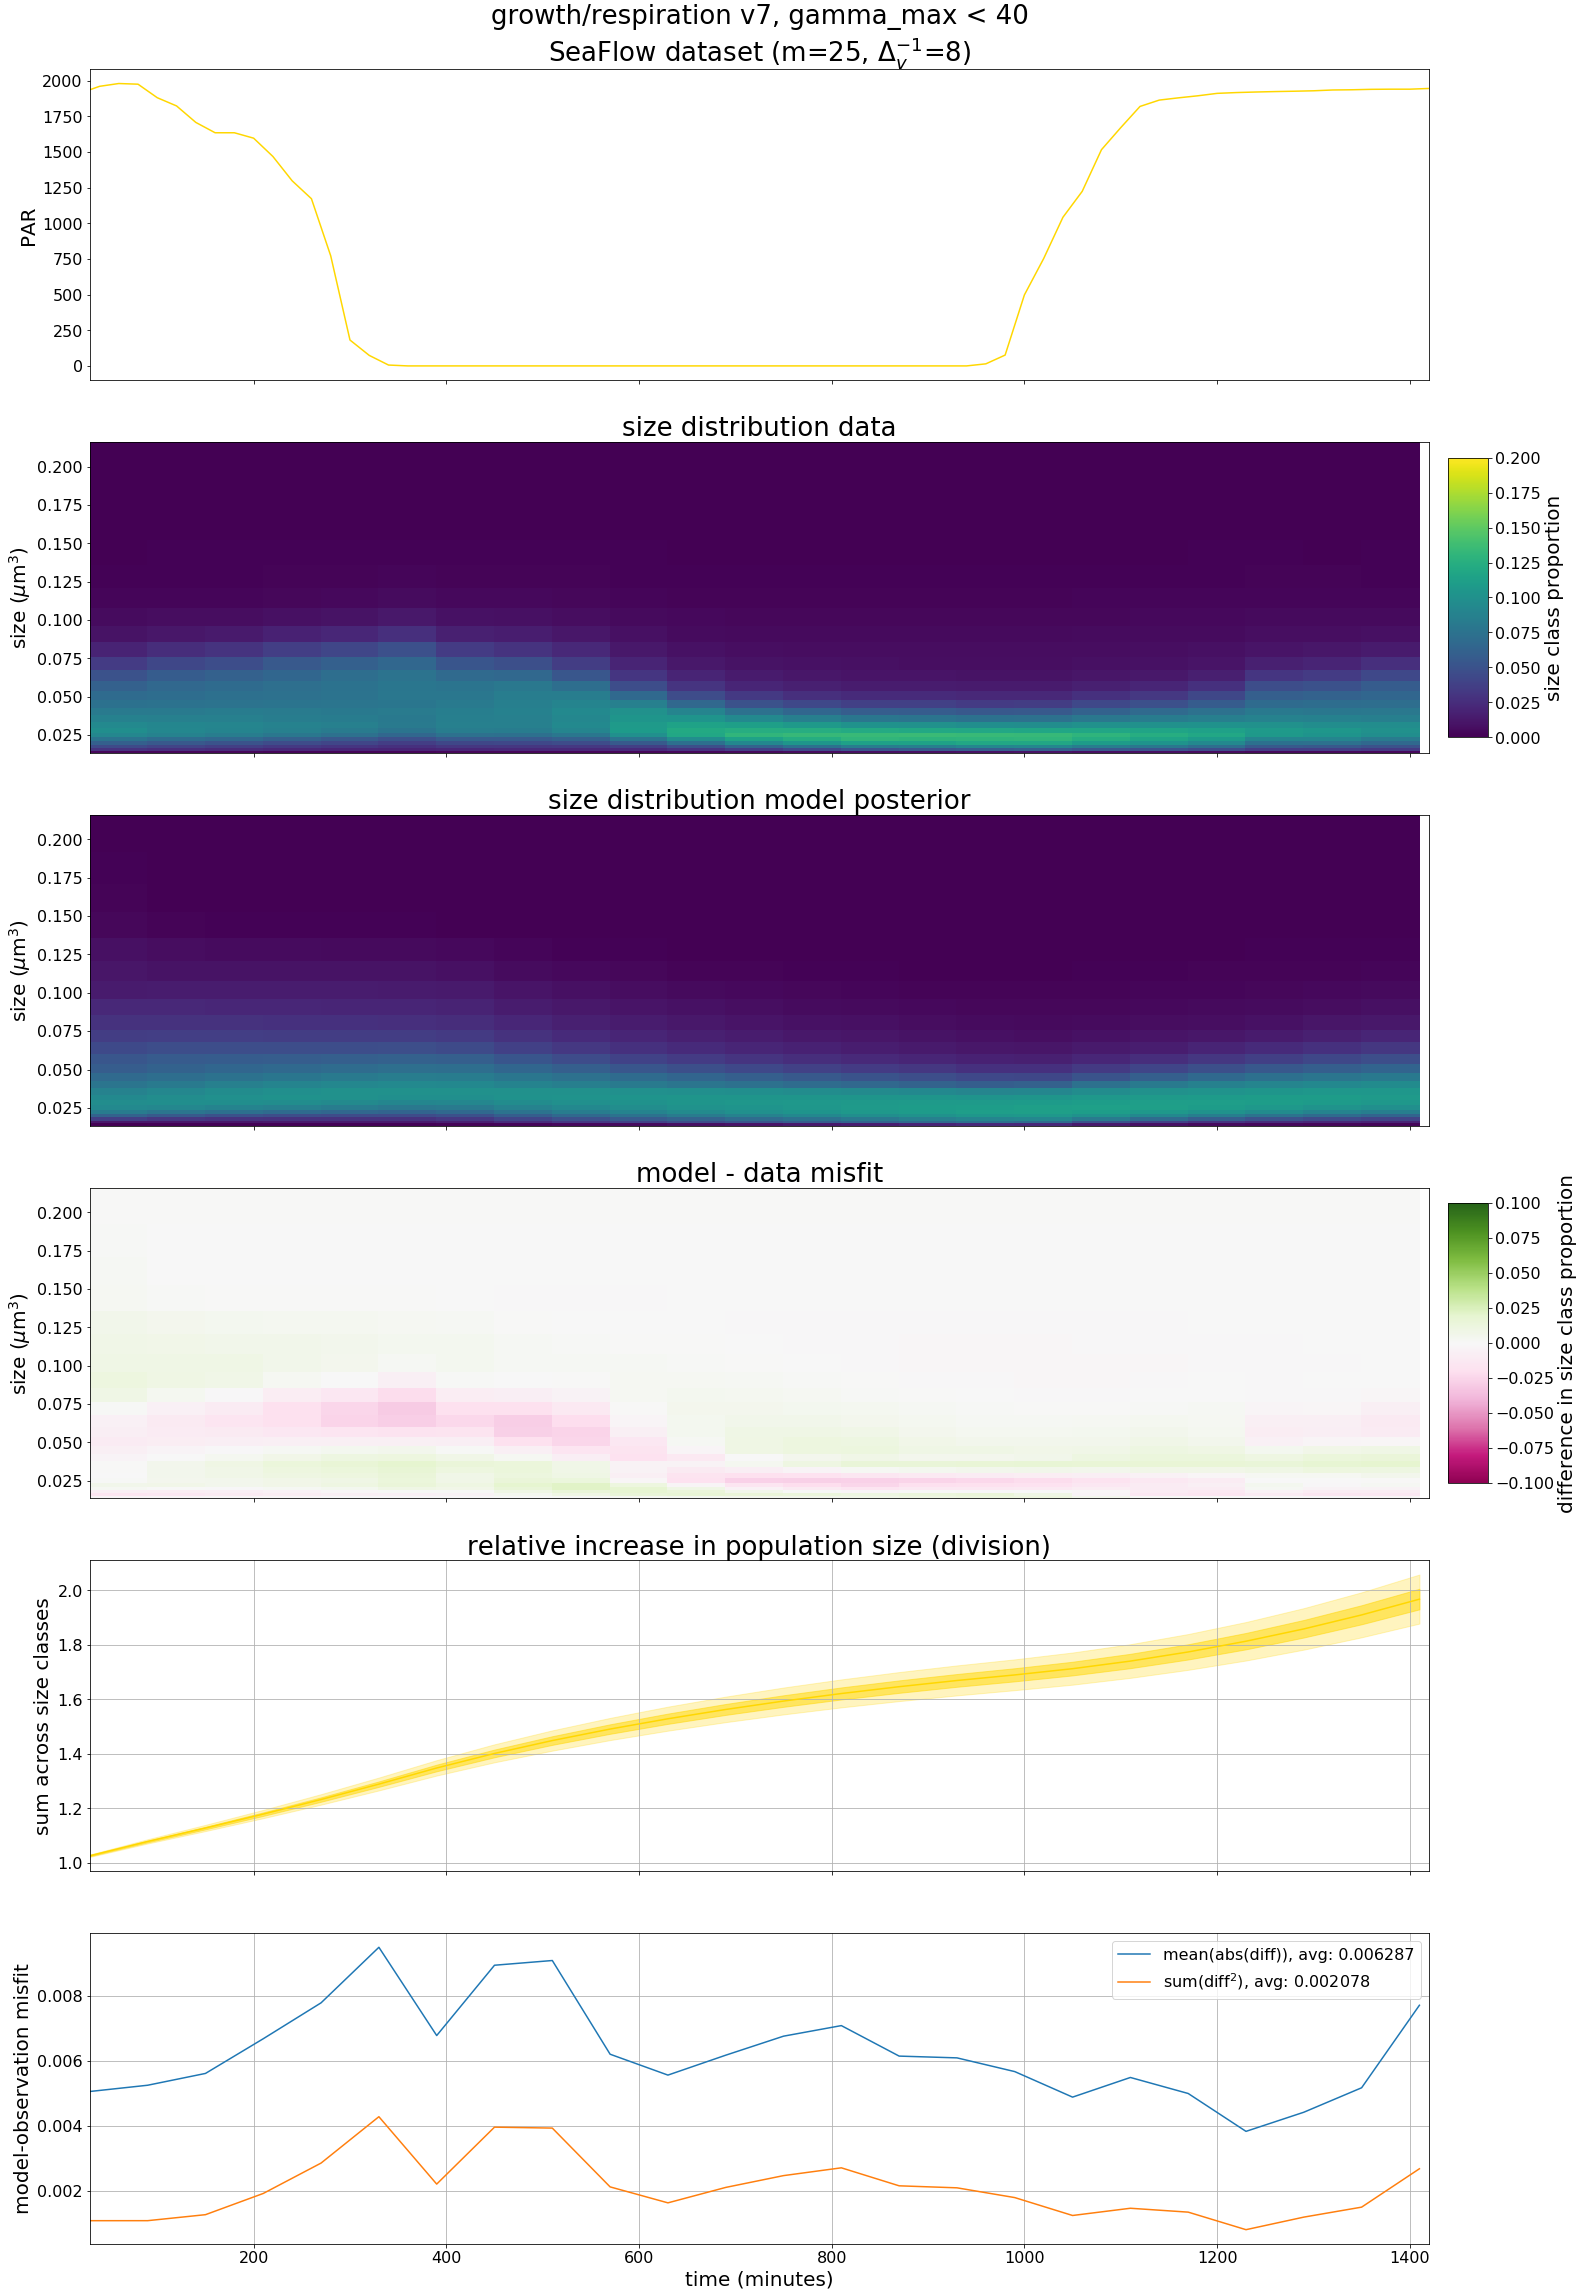

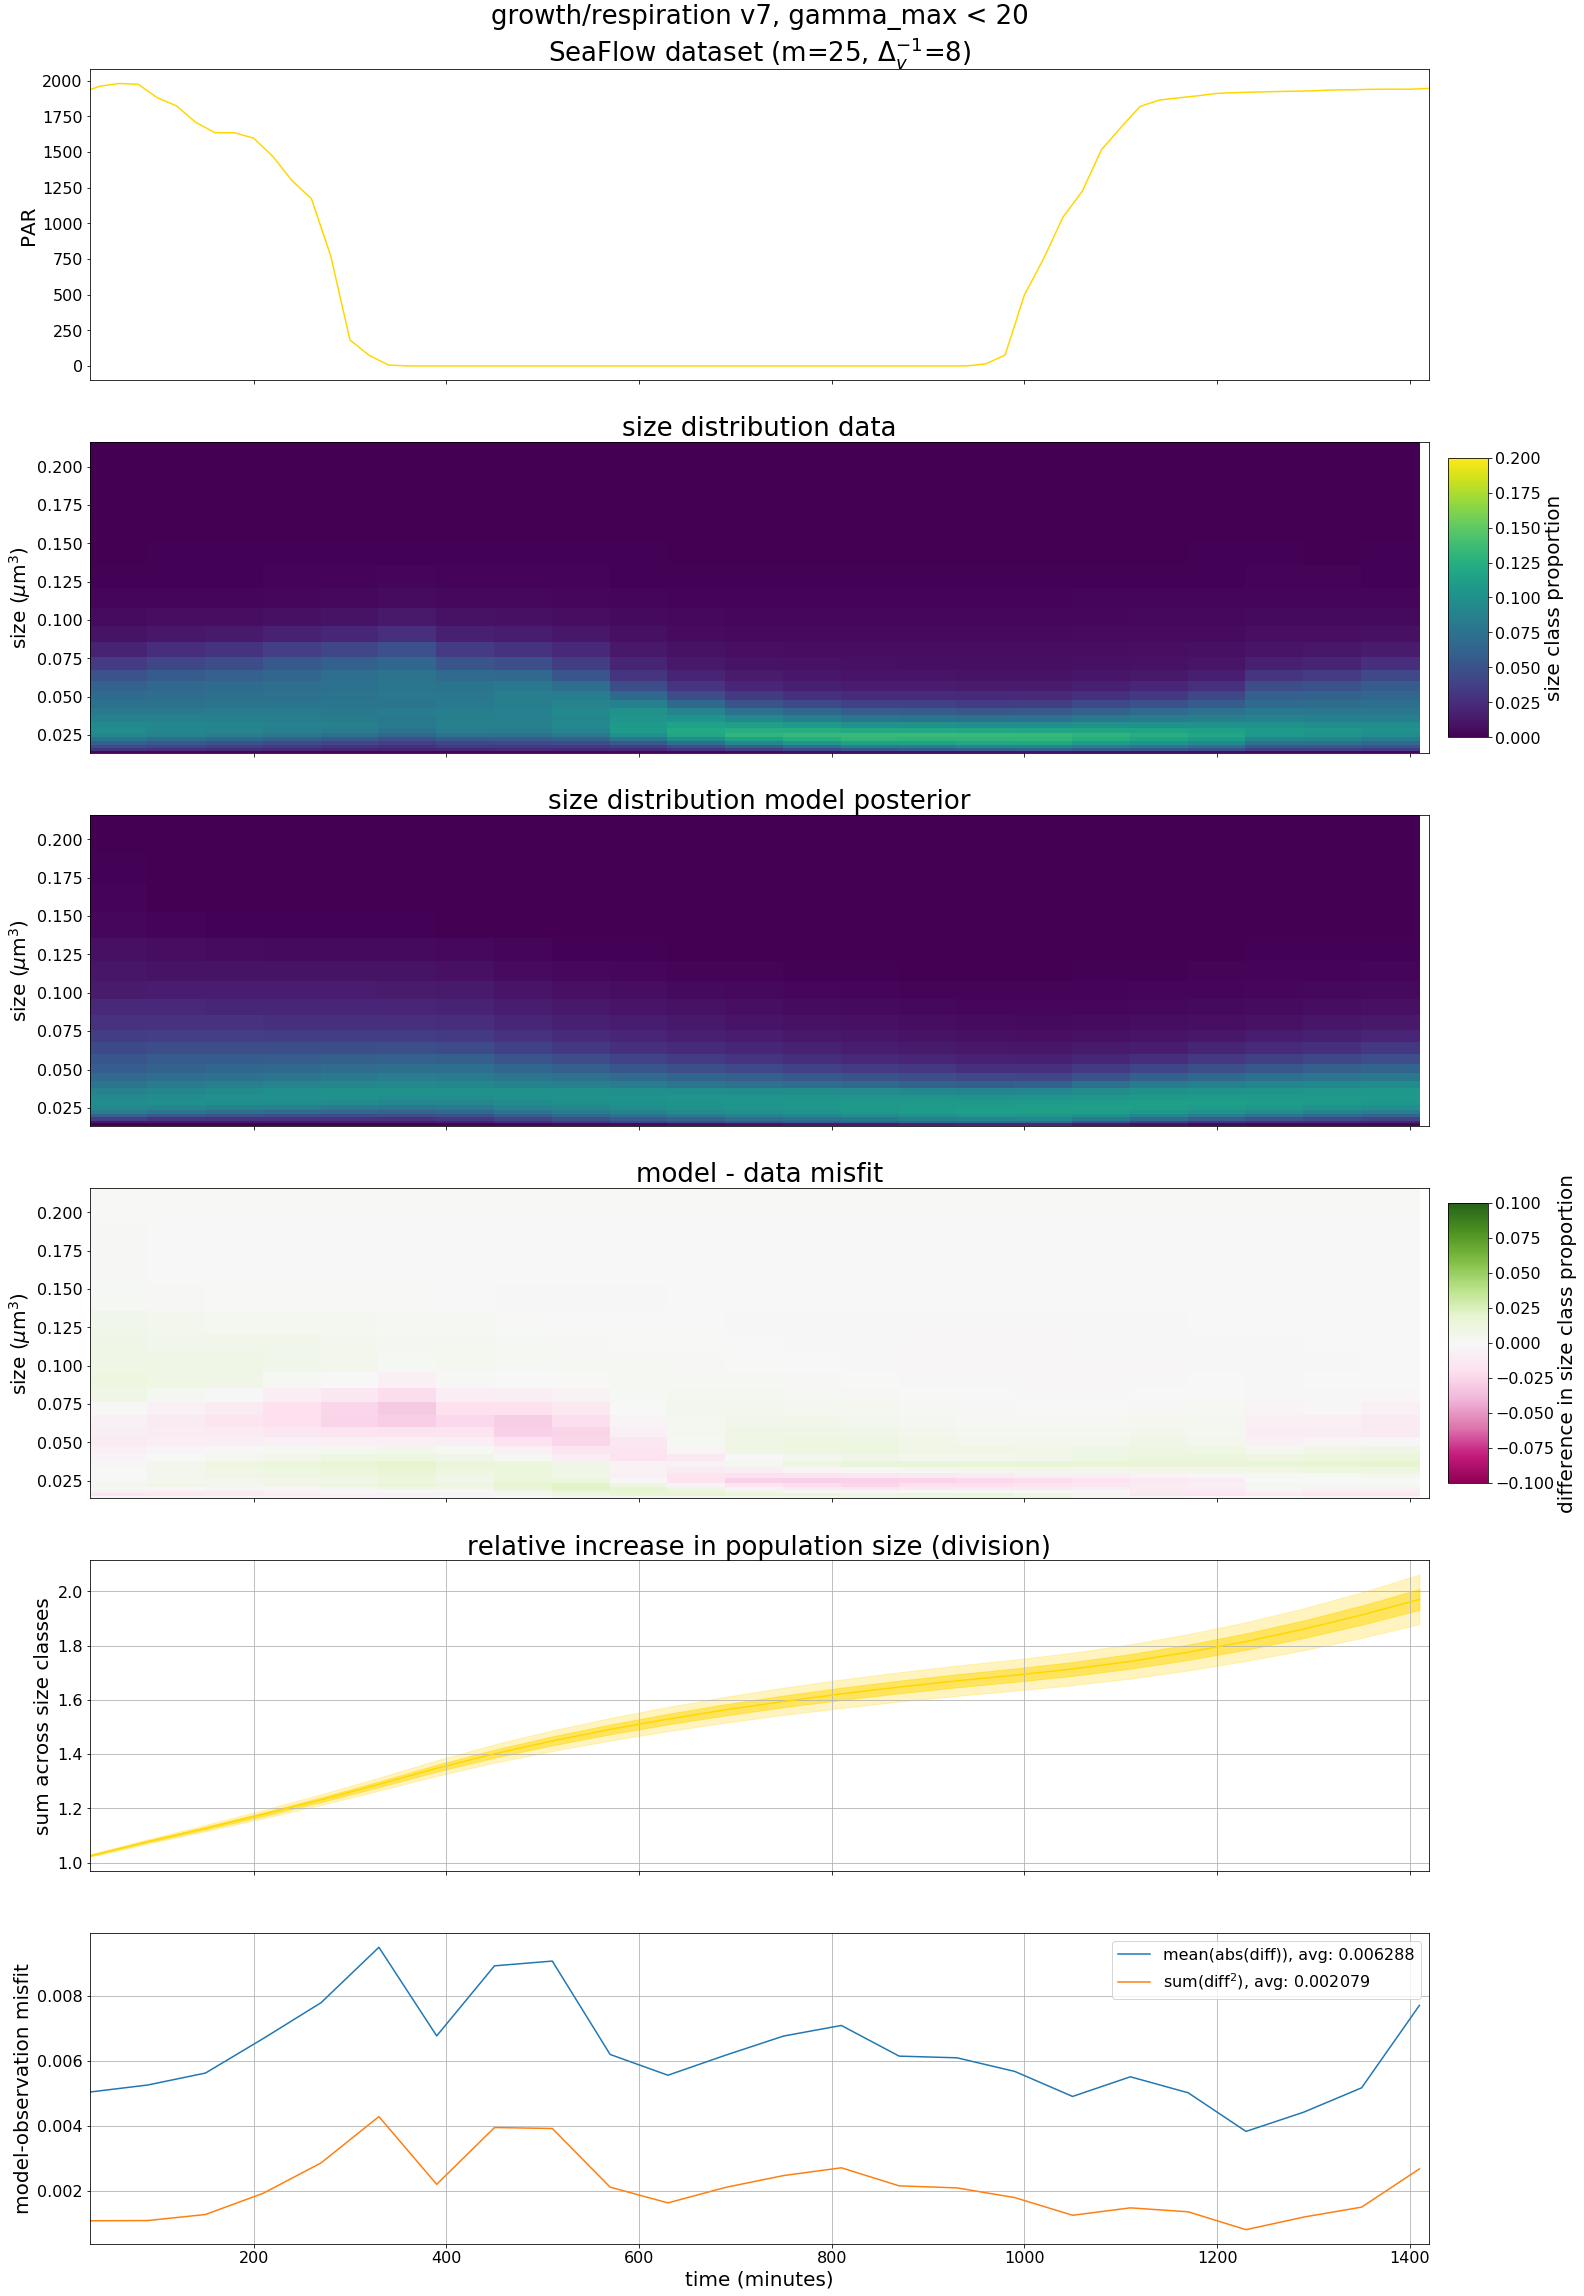

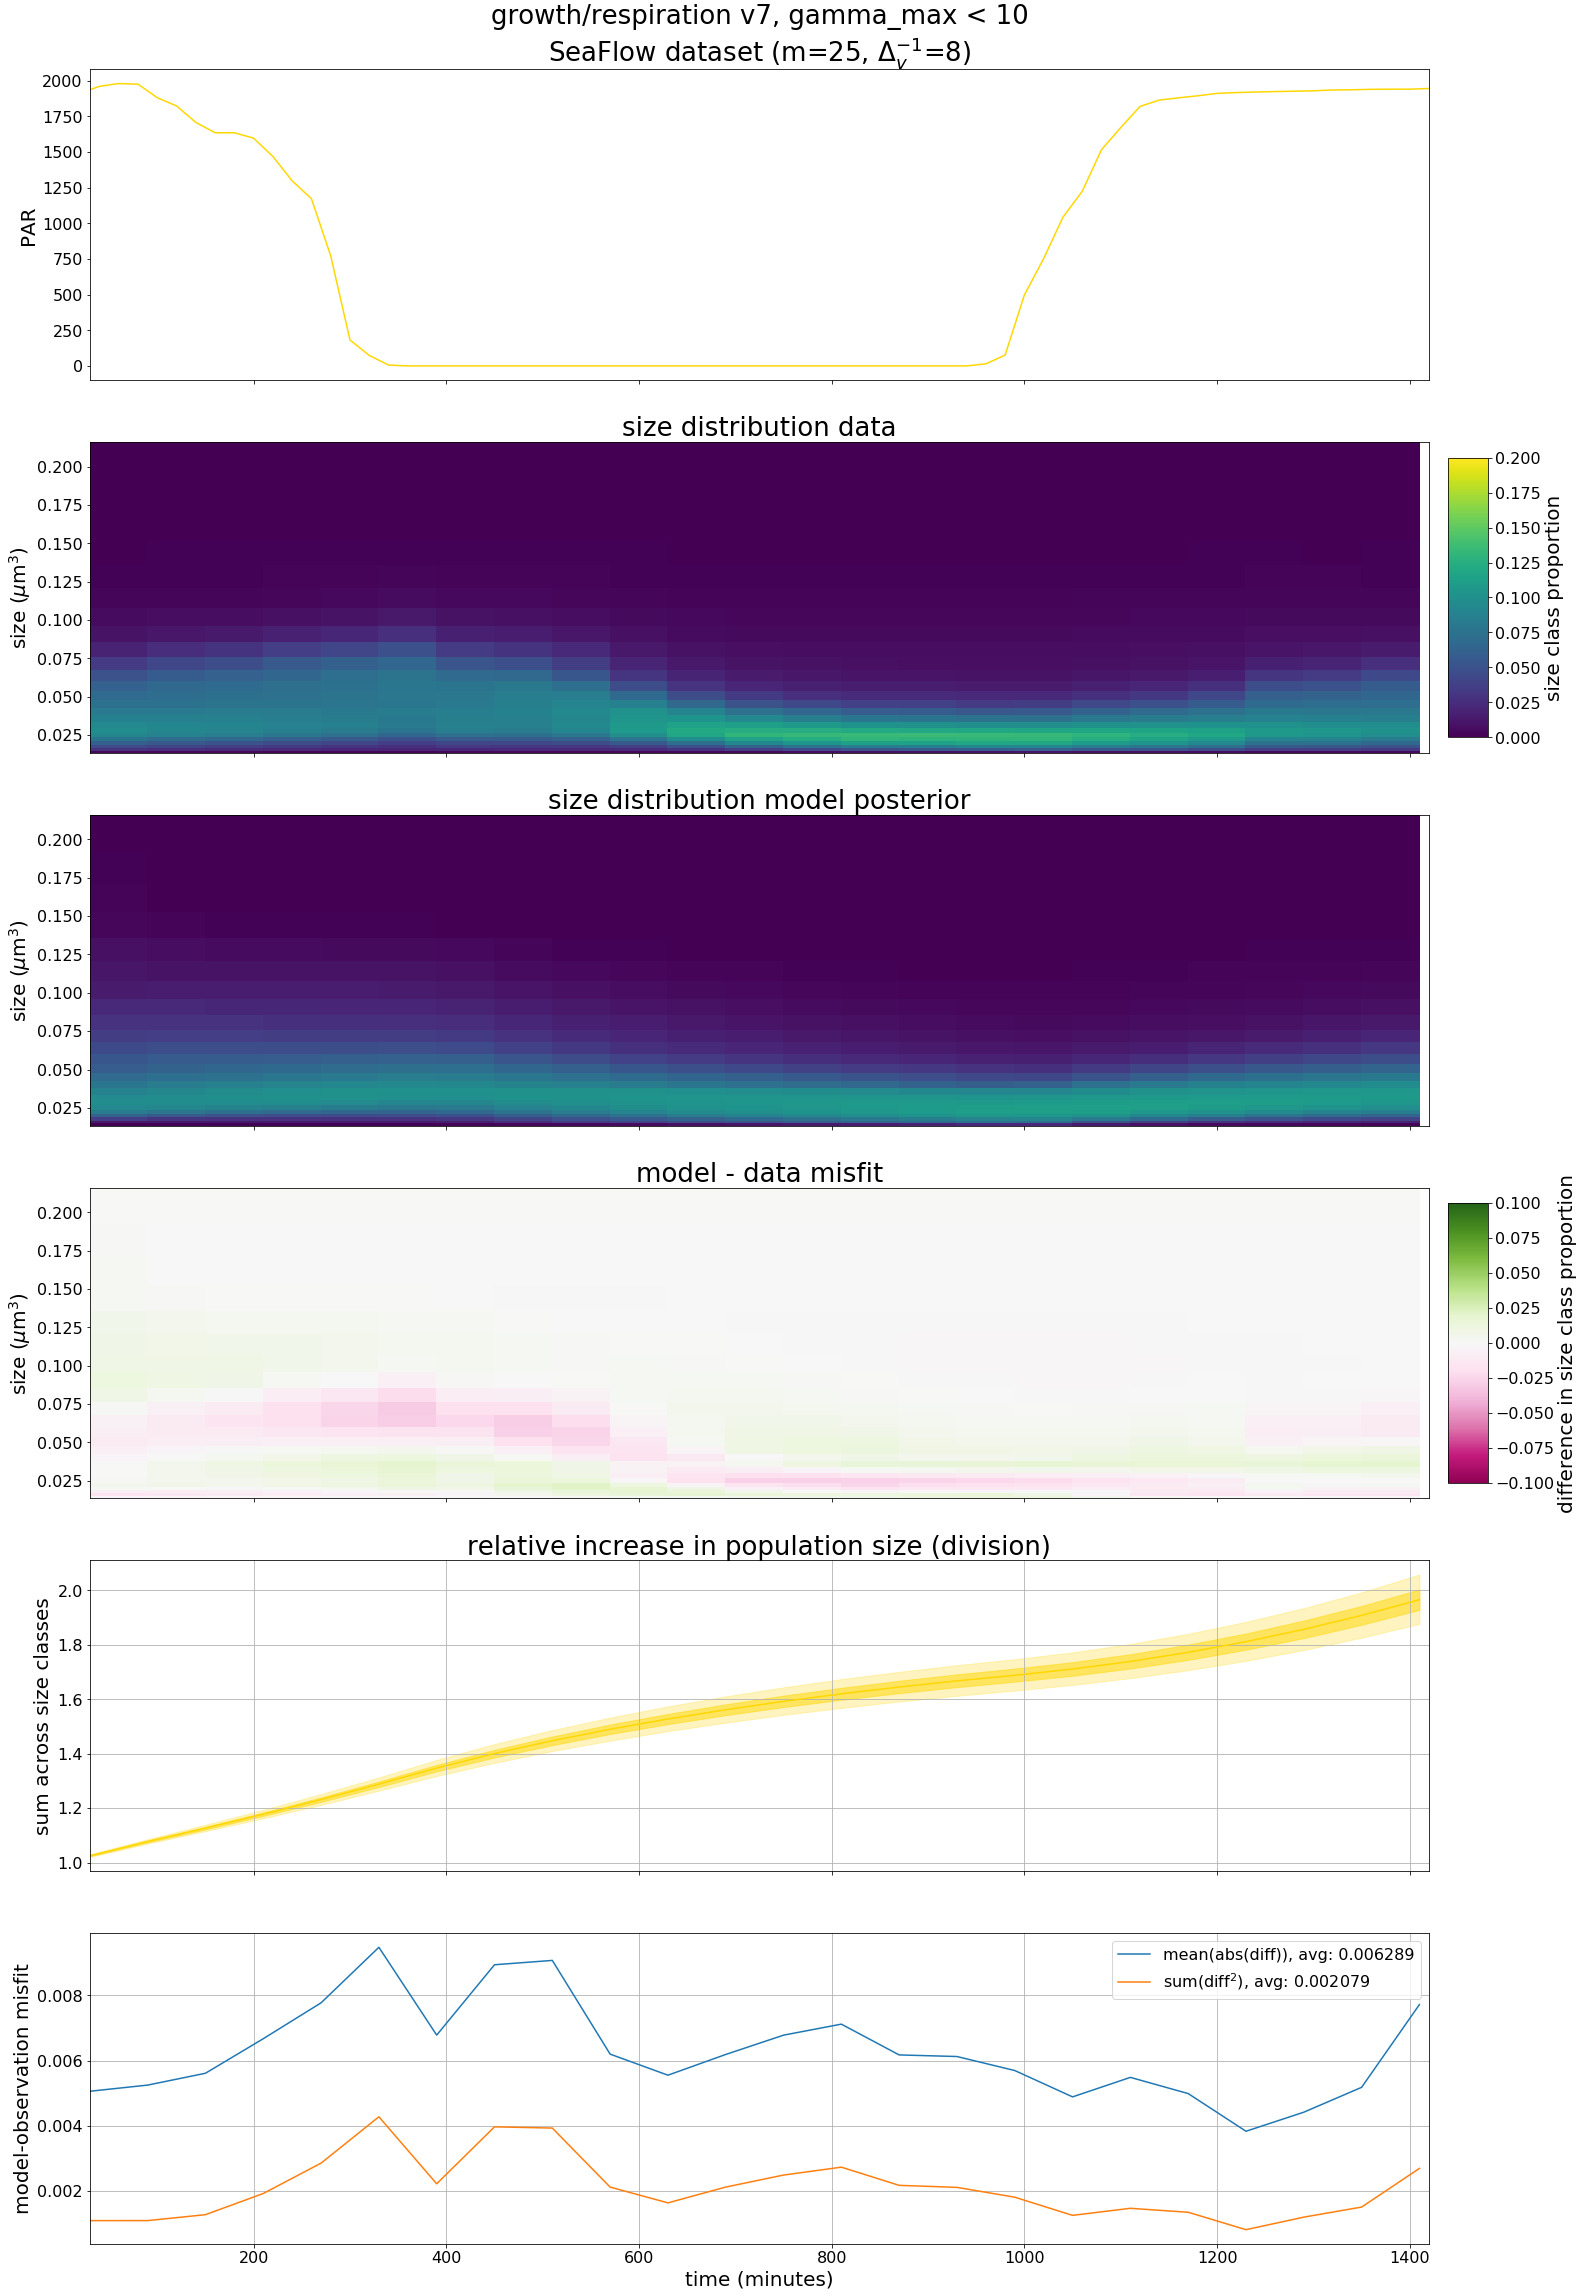

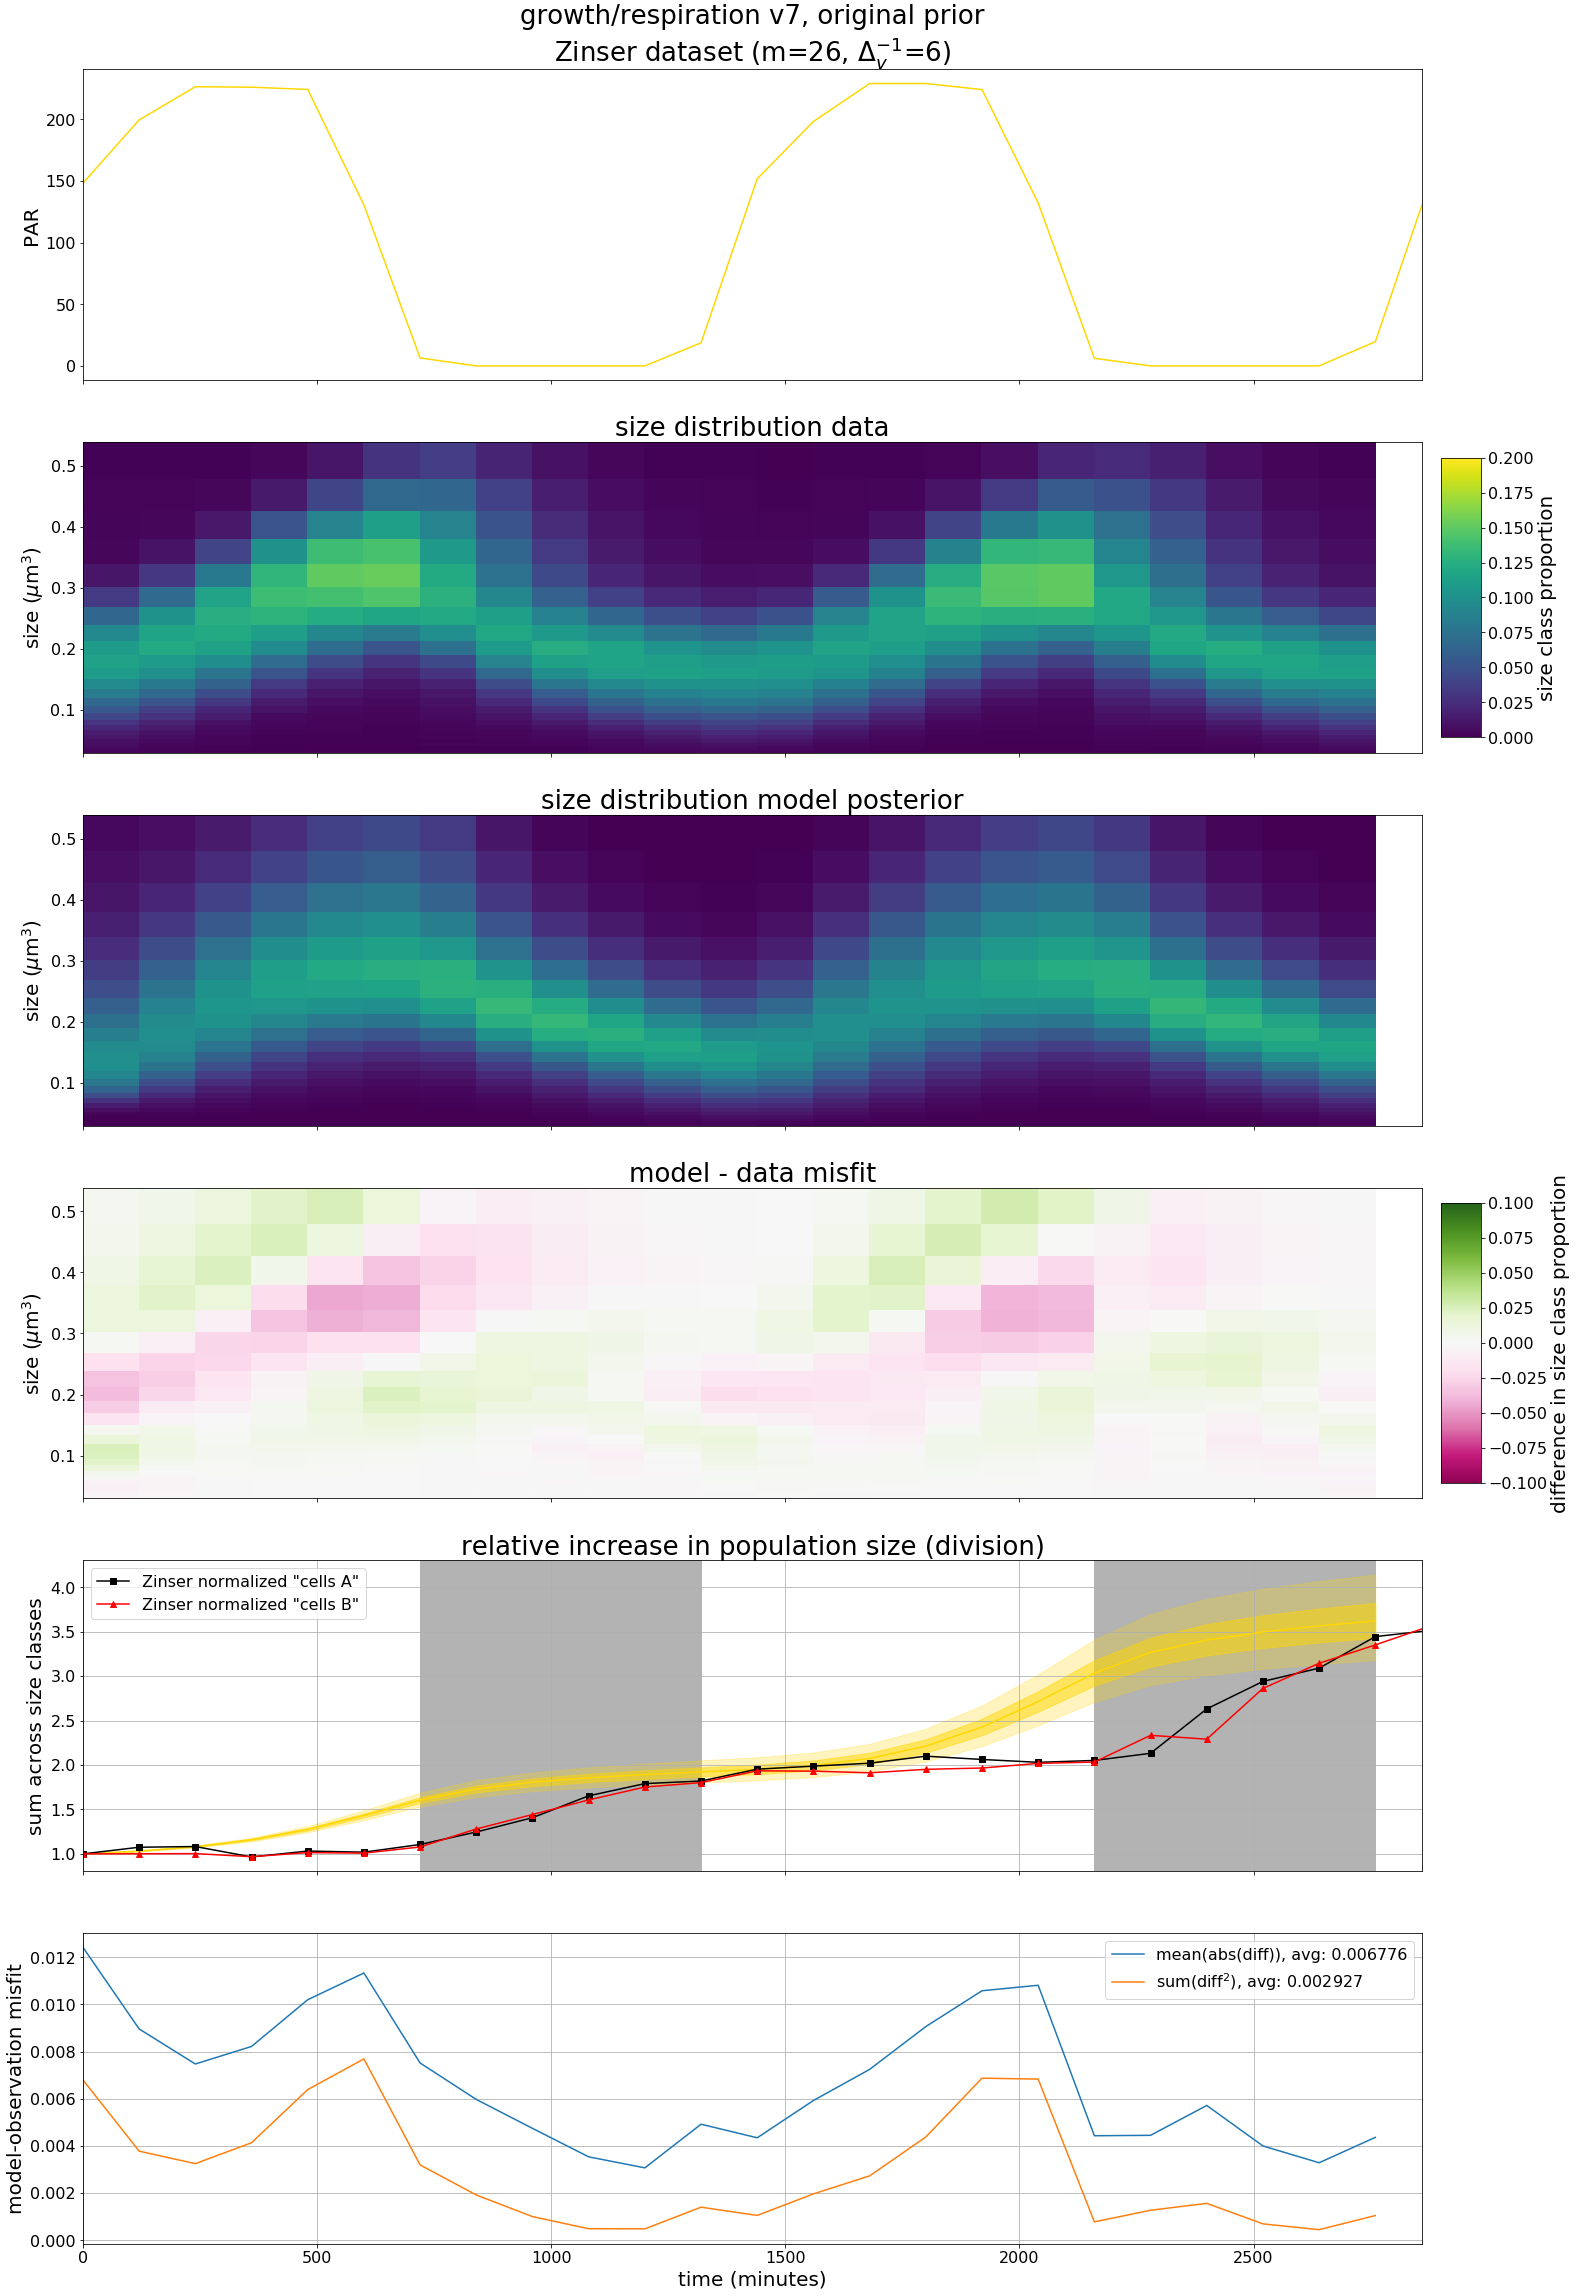

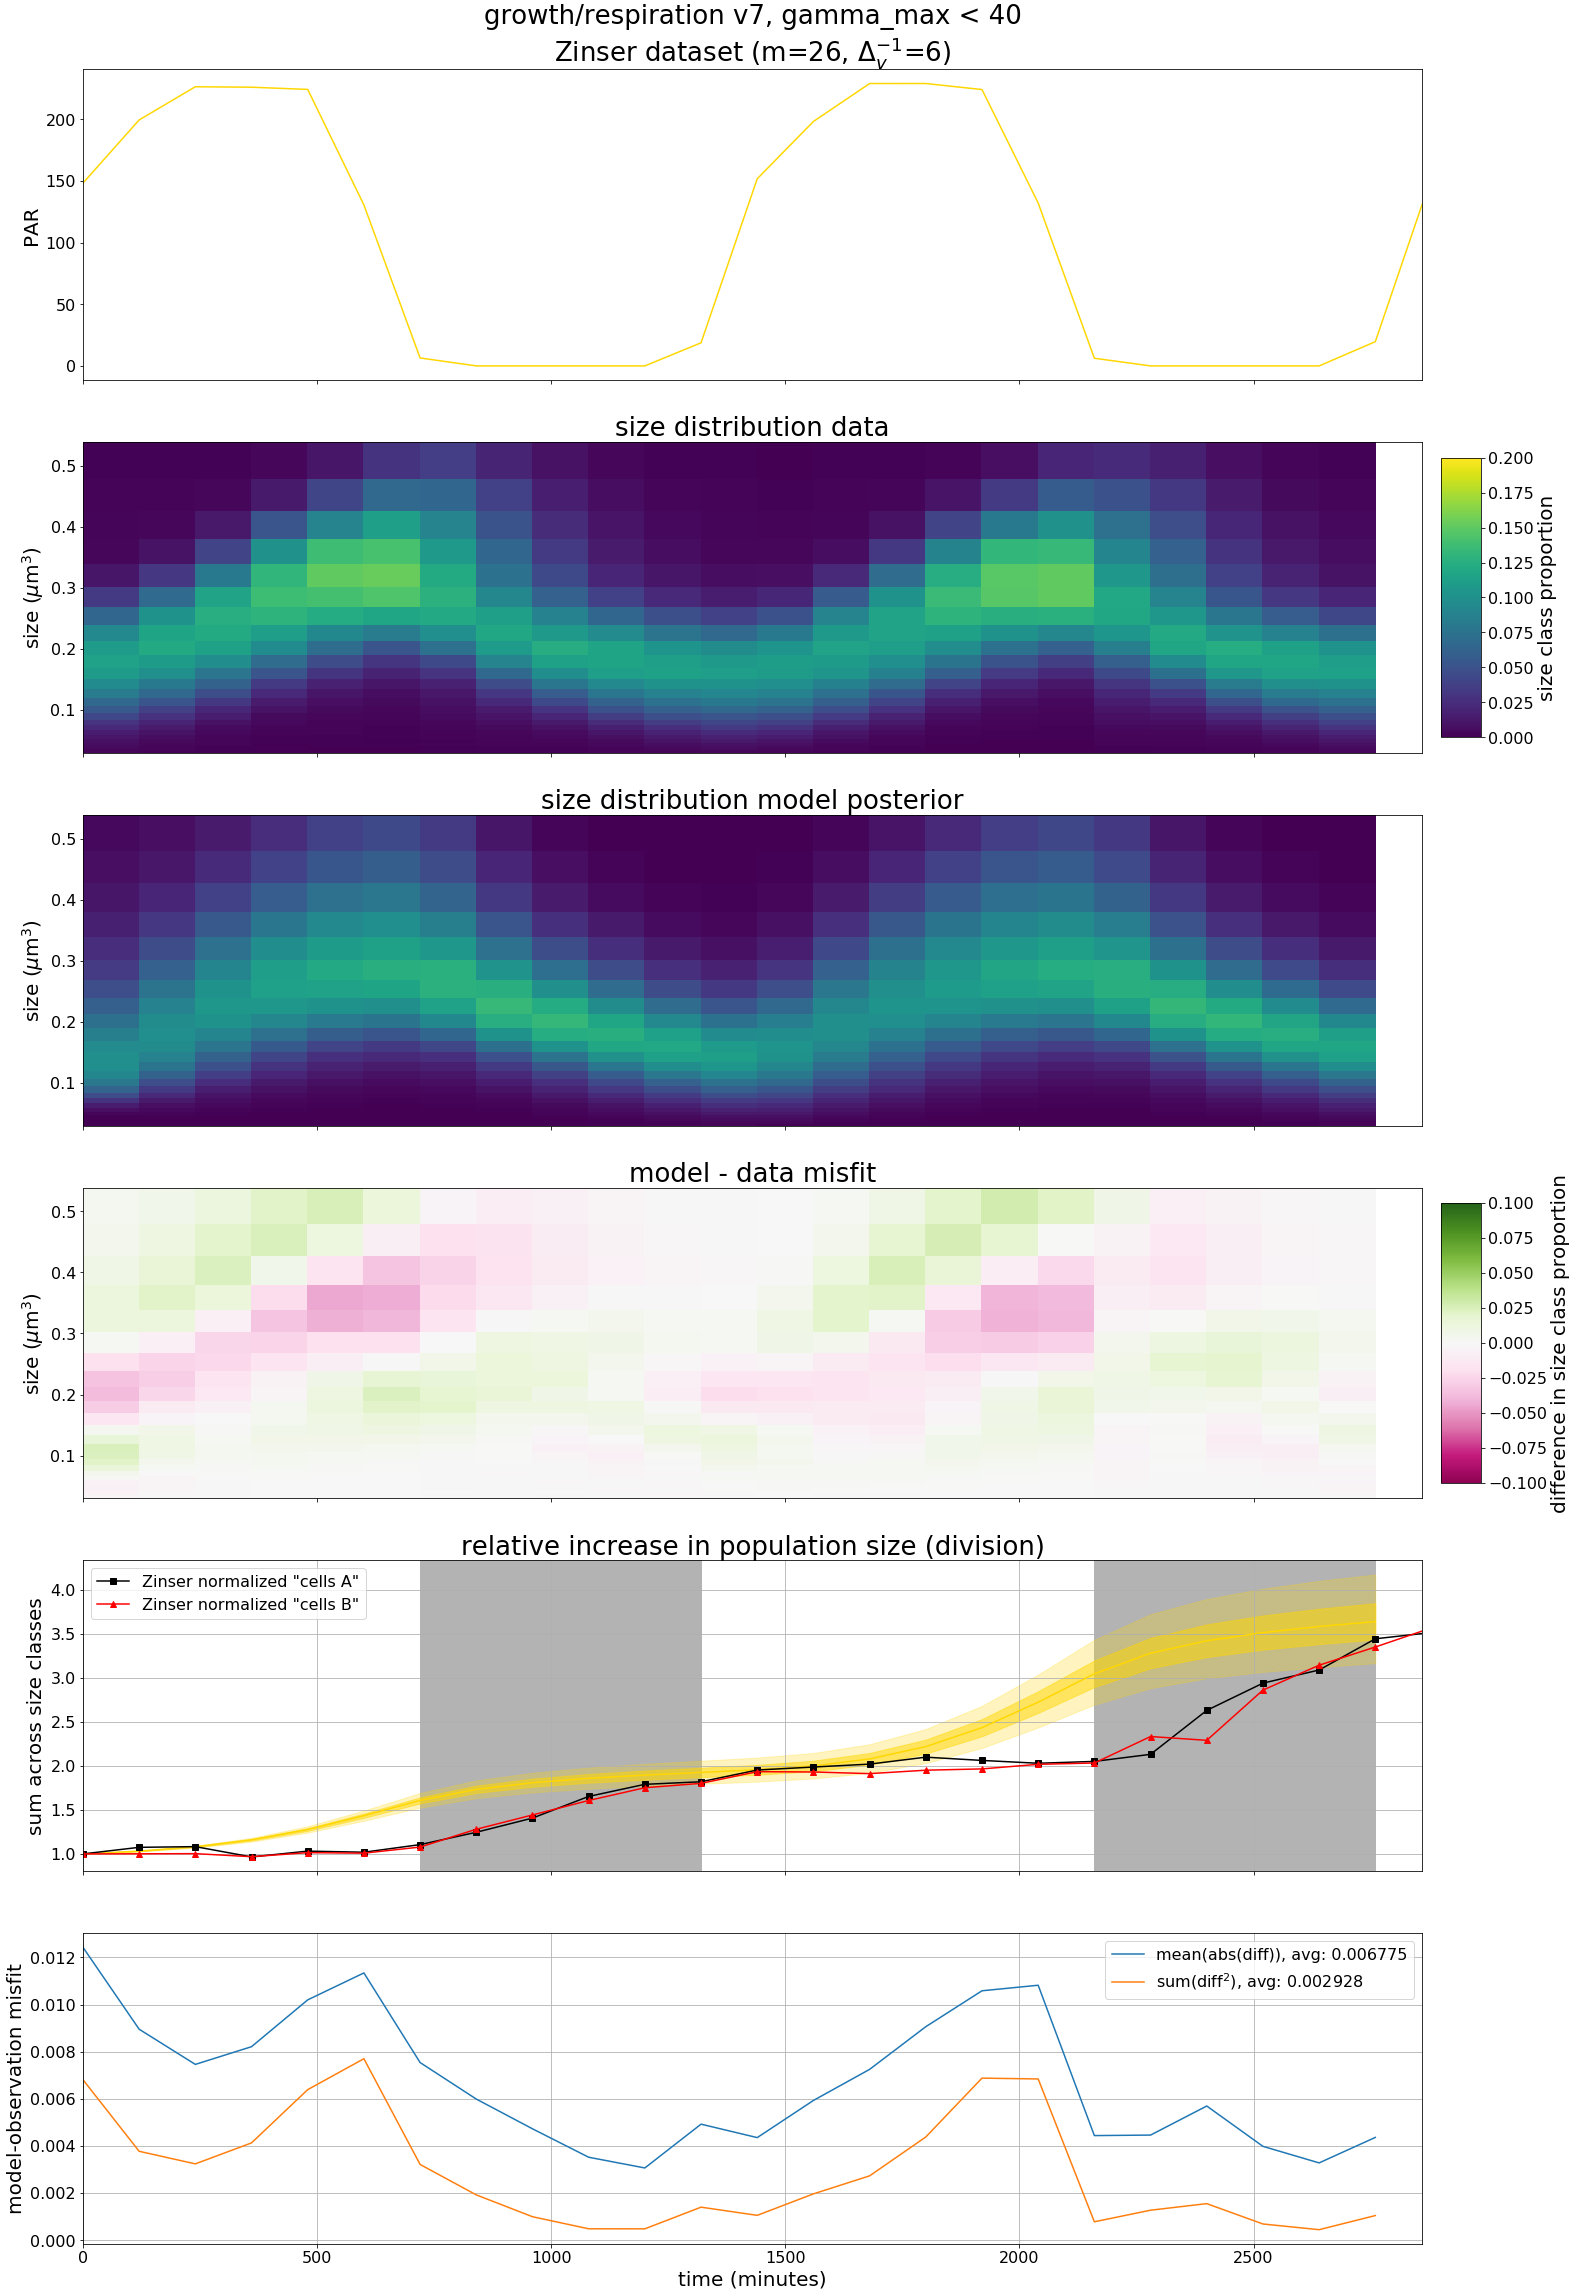

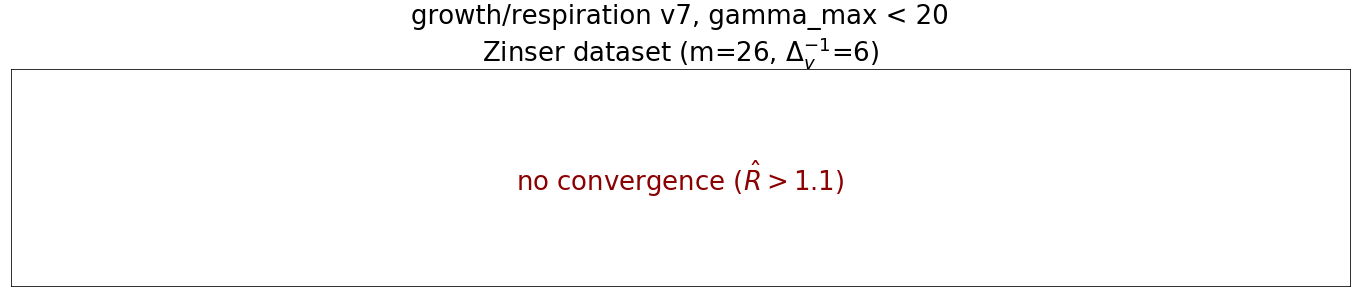

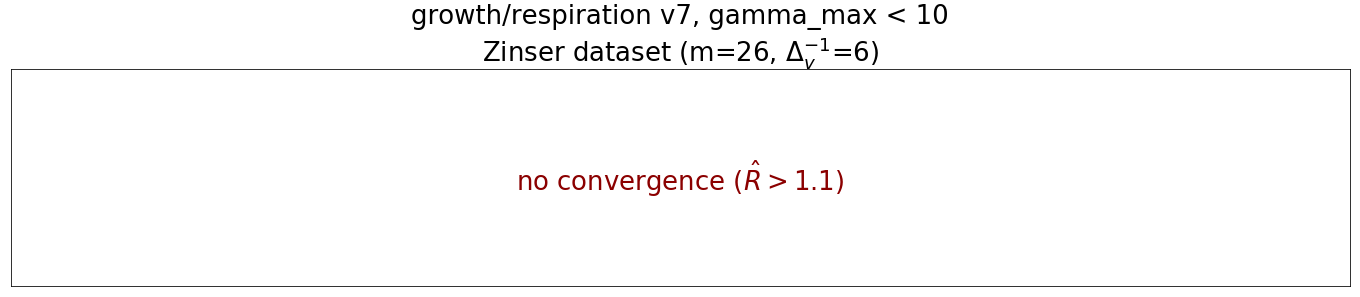

In [12]:
import pandas

data_fig2a = pandas.read_csv('data/Zinser_Figure2A.csv')

t_zinser = data_fig2a['exper time'] * 60
a_norm = data_fig2a['cells A'].copy()
a_norm /= a_norm[0]
b_norm = data_fig2a['cells B'].copy()
b_norm /= b_norm[0]

colors = {'model':'darkred', 'obs':'0.1'}

norm = mpl.colors.Normalize(0.0,0.2)
norm_diff = mpl.colors.Normalize(-0.1,0.1)

for dataname in data:
    for name,mcmc in mcmcs.items():
        t = data[dataname]['dt']*np.arange(data[dataname]['nt'])
        v_ext = data[dataname]['v_min'] * 2**(np.arange(data[dataname]['m']+1)*delta_v) 
        v = v_ext[:-1]
        v_width = v_ext[1:] - v_ext[:-1]
        
        res = {'model':np.mean(mcmc[dataname]['mod_obspos'], axis=0), 'obs':data[dataname]['obs']}
        res_sum1 = res['model']/np.sum(res['model'], axis=0)[None,:]
        diff = res_sum1-res['obs']

        if maxrhats_final[name][dataname] > 1.1:
            fig, ax = plt.subplots(figsize=(24,4))
            ax.set_title(desc_model[name] + '\n' + desc[dataname])
            ax.set(xticks=[], yticks=[])
            ax.text(0.5, 0.5, 'no convergence ($\\hat{R}>1.1$)', color='darkred', size=26, transform=ax.transAxes, ha='center', va='center')
            continue
        
        fig,axs = plt.subplots(6,1,sharex=True,figsize=(24,40))
        axs[0].set_title(desc_model[name] + '\n' + desc[dataname])

        ax = axs[0]
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(xlim=(data[dataname]['t_obs'][0],t[-1]), ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res['obs'],norm=norm)
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution data')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        ax.set(ylabel='size ($\mu$m$^3$)', title='size distribution model posterior')
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,res_sum1,norm=norm)

        ax = axs[3]
        pc = ax.pcolormesh(data[dataname]['t_obs'],v,diff,norm=norm_diff, cmap='PiYG')
        ax.set(ylabel='size ($\mu$m$^3$)', title='model - data misfit')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='difference in size class proportion')
        
        qq = np.percentile(np.sum(mcmc[dataname]['mod_obspos'], axis=1), axis=0, q=(5,25,50,75,95))
    
        ax = axs[4]
        ax.fill_between(data[dataname]['t_obs'], qq[0,:], qq[-1,:], alpha=0.25, color='gold')
        ax.fill_between(data[dataname]['t_obs'], qq[1,:], qq[-2,:], alpha=0.5, color='gold')
        ax.plot(data[dataname]['t_obs'], qq[2,:], color='gold')
        if 'zinser' in dataname:
            ax.plot(t_zinser, a_norm, color='black', marker='s', label='Zinser normalized "cells A"')
            ax.plot(t_zinser, b_norm, color='red', marker='^', label='Zinser normalized "cells B"')
            for iday in range(2):
                ax.axvspan(iday*24*60+12*60, iday*24*60+22*60, color='0.7', zorder=0)
            ax.legend()
        ax.grid(True)
        ax.set(ylabel='sum across size classes', title='relative increase in population size (division)')

        ax = axs[5]
        prop = np.mean(np.abs(diff),axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='mean(abs(diff)), avg: {:.6f}'.format(np.mean(prop)))
        prop = np.sum(diff**2,axis=0)
        ax.plot(data[dataname]['t_obs'], prop, label='sum(diff$^2$), avg: {:.6f}'.format(np.mean(prop)))
        ax.set(xlabel='time (minutes)', ylabel='model-observation misfit')
        ax.grid(True)
        ax.legend()